# Flight price predicting

## Truncating Data

- initial dataset was way to large (30GB deserialized)
- because the crawler for the data ran every day the initial data has a time-series-component 

### Solutions

-> Look at the amount of crawled entry for each working day, choose date with good amount of entries (2022.05.11)

This way we cut most of the data while also losing the time series component. (2 Fliegen mit einer Klatsche)

*** From now own all further processing and training steps will also account for the new truncated dataset: "searchDate_2022-05.11" ***

Well then lets get to cooking UwU

## Dataset Overhead

This section is for imports, data fetching, first train test split

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
# get data
data_raw = pd.read_csv("../data/truncated/searchDate_2022-05-11.csv")

## Data Exploration

Overview and description of each column in the flight data:

### Journey Identification

  * **legId**: A unique identifier for each flight option or itinerary presented in the search.
  * **searchDate**: The date on which the flight search was conducted (in this file, '2022-05-11').
  * **flightDate**: The date the flight is scheduled to depart.

-----

### Route and Duration

  * **startingAirport**: The IATA airport code for the origin of the entire journey (e.g., 'ATL' for Atlanta).
  * **destinationAirport**: The IATA airport code for the final destination of the entire journey (e.g., 'BOS' for Boston).
  * **travelDuration**: The total time for the journey, from the first departure to the last arrival, including layovers. It's in a standard duration format (e.g., 'PT2H35M' means 2 hours and 35 minutes).
  * **elapsedDays**: The number of calendar days the journey spans. '0' means departure and arrival are on the same day, '1' would typically mean an overnight flight.
  * **totalTravelDistance**: The total distance of the journey, likely in miles. Note that this column has some missing values.

-----

### Fare and Ticket Details

  * **fareBasisCode**: An internal airline code that specifies the fare type, rules, and booking class.
  * **isBasicEconomy**: A 'True'/'False' value indicating if the fare is a restrictive 'basic economy' ticket.
  * **isRefundable**: A 'True'/'False' value indicating if the ticket fare is refundable.
  * **isNonStop**: A 'True'/'False' value indicating if the journey has no layovers (i.e., it's a direct flight).
  * **baseFare**: The price of the ticket before any taxes or fees are added.
  * **totalFare**: The final price of the ticket, including the base fare, taxes, and all fees.
  * **seatsRemaining**: The number of seats available on the flight(s) at this particular fare.

-----

### Flight Segments

For journeys with one or more stops (segments), the following columns contain details for each segment, separated by a '||' delimiter.

  * **segmentsDepartureTimeEpochSeconds**: The departure time for each flight segment, represented in Unix epoch seconds.
  * **segmentsDepartureTimeRaw**: The departure time for each segment in a human-readable format (ISO 8601), including date, time, and timezone information.
  * **segmentsArrivalTimeEpochSeconds**: The arrival time for each flight segment in Unix epoch seconds.
  * **segmentsArrivalTimeRaw**: The arrival time for each segment in a human-readable format, including timezone.
  * **segmentsArrivalAirportCode**: The IATA airport code for each segment's arrival airport.
  * **segmentsDepartureAirportCode**: The IATA airport code for each segment's departure airport.
  * **segmentsAirlineName**: The name of the airline operating each segment (e.g., 'American Airlines').
  * **segmentsAirlineCode**: The two-letter IATA code for the airline operating each segment (e.g., 'AA').
  * **segmentsEquipmentDescription**: The type of aircraft used for each segment (e.g., 'Airbus A319'). This column has some missing values.
  * **segmentsDurationInSeconds**: The duration of each individual flight segment in seconds.
  * **segmentsDistance**: The distance of each individual flight segment. This column has some missing values.
  * **segmentsCabinCode**: The cabin class for each segment (e.g., 'coach').


*** Before even starting with looking at the data statistics we have to do some transformation to the data segments ***

-> Lets try to transform all the segment columns so useable column instead of just strings with some weird delimiter.

First thought would be to only keep the data for flights with 2 stops. But we should check what the max amount of stops is. To just remove to many data points that have more then 2 would maybe bias our predictions because their price will obviously be higher than flights with 2 stops.

In [3]:
# Transform Segment columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Calculate the number of segments
# The number of segments is 1 + the number of '||' delimiters
# We use a non-segment column like 'segmentsAirlineName' for this calculation
data_raw['num_segments'] = data_raw['segmentsAirlineName'].astype(str).str.count('\|\|') + 1

# The number of stops is the number of segments - 1
data_raw['num_stops'] = data_raw['num_segments'] - 1

# Calculate the max and mean number of stops
max_stops = data_raw['num_stops'].max()
mean_stops = data_raw['num_stops'].mean()

print(f"Maximum number of stops: {max_stops}")
print(f"Mean number of stops: {mean_stops:.2f}")

# Get the distribution of stops
stops_distribution = data_raw['num_stops'].value_counts().sort_index()
stops_distribution_percent = data_raw['num_stops'].value_counts(normalize=True).sort_index() * 100

print("\nDistribution of stops (count):")
print(stops_distribution)

print("\nDistribution of stops (percentage):")
print(stops_distribution_percent.apply(lambda x: f"{x:.2f}%"))



Maximum number of stops: 3
Mean number of stops: 0.79

Distribution of stops (count):
num_stops
0    32629
1    71262
2     8279
3      142
Name: count, dtype: int64

Distribution of stops (percentage):
num_stops
0    29.05%
1    63.45%
2     7.37%
3     0.13%
Name: proportion, dtype: object


### Interpretation of Segment Data

This brings some really interesting insights. The distribution of the amount of stops has a very large tail to the right. Now the questions arises: How do we handle this now.

1. We could declare all flights with 3 stops as outlier and just remove all datapoints (information loss)
2. We keep all the data and later look in the correlation analysis and feature engineering section if we cut any

-> For now we keep all the data possible. But how? We will create a lot of new columns to handle this for now.
Similar to one hot encoding each segment column will get 4 new columns with data for each step

-> This will result in a lot more sparse dataset but this can be looked at / handled later.


In [4]:
# Transform Segment Columns
# --- Wide Format (Pivoting) ---

# First, find the maximum number of segments in the data.
# We know from our previous analysis that max stops is 3, so max segments is 4.
max_segments = 4

# Identify all the 'segments...' columns that need to be split
segment_cols = [col for col in data_raw.columns if col.startswith('segments')]

print(f"Original segment columns to be transformed: {segment_cols}")
print(f"Maximum segments to create: {max_segments}\n")

# Loop through each segment column and split it
for col in segment_cols:
    # Get the "base name" e.g., "AirlineName" from "segmentsAirlineName"
    base_name = col.replace('segments', '')

    # Create a list of new column names, e.g.,
    # ['segment_1_AirlineName', 'segment_2_AirlineName', ...]
    new_cols = [f"segment_{i+1}{base_name}" for i in range(max_segments)]

    # Split the string column by '||'
    # expand=True turns the split lists into new columns
    # The result is a new DataFrame
    split_df = data_raw[col].astype(str).str.split('\|\|', expand=True)

    # Ensure we only take up to `max_segments` columns from the split
    # in case any row has more (unlikely, but safe)
    split_df = split_df.iloc[:, :max_segments]

    # Rename the columns of the new DataFrame
    # We must match the number of columns we have
    split_df.columns = new_cols[:split_df.shape[1]]

    # If the max split was less than max_segments (e.g., max was 3, but we set 4),
    # add the missing columns and fill with None (NaN)
    for i in range(split_df.shape[1], max_segments):
        split_df[new_cols[i]] = np.nan

    # Concatenate the new split columns back to the main DataFrame
    data_raw = pd.concat([data_raw, split_df], axis=1)

    # Drop the original, unprocessed 'segments...' column
    data_raw = data_raw.drop(columns=[col])


print(f"\n--- Transformation Complete ---")

# Print info and head to show the new structure
print("\nNew DataFrame structure (first 100 columns):")
print(data_raw.info(verbose=True, max_cols=100))

print("\nFirst 5 rows of transformed data (sample columns):")
# Show a subset of original and new columns to demonstrate the change
columns_to_show = ['legId', 'startingAirport', 'destinationAirport', 'isNonStop',
                   'segment_1DepartureTimeRaw', 'segment_1ArrivalAirportCode',
                   'segment_2DepartureTimeRaw', 'segment_2ArrivalAirportCode',
                   'segment_3DepartureTimeRaw', 'segment_3ArrivalAirportCode']
# Filter to only columns that exist (e.g., in case of error)
columns_to_show = [c for c in columns_to_show if c in data_raw.columns]
print(data_raw[columns_to_show].head())

Original segment columns to be transformed: ['segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode']
Maximum segments to create: 4


--- Transformation Complete ---

New DataFrame structure (first 100 columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112312 entries, 0 to 112311
Data columns (total 65 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   legId                               112312 non-null  object 
 1   searchDate                          112312 non-null  object 
 2   flightDate                          112312 non-null  object 
 3   startingAirport                     112312 non-null  object 
 4

This already looks a lot better. Just one more thing that stands out are the datatypes. 
They could be set a little better the make next steps easier.

In [5]:
# --- Data Type Conversion ---
print("\n--- Starting Data Type Conversion ---")

# 1. Clean up 'nan' and 'None' strings
# Get a list of all newly created segment columns
segment_cols_new = [col for col in data_raw.columns if col.startswith('segment_')]

# Replace string 'nan' or 'None' with actual np.nan
# This is crucial because .astype(str) created these strings from empty values
data_raw[segment_cols_new] = data_raw[segment_cols_new].replace({'nan': np.nan, 'None': np.nan})
print("Replaced 'nan' strings with np.nan.")

# 2. Convert Date and Datetime columns
print("Converting date/time columns...")
# Main dates
data_raw['searchDate'] = pd.to_datetime(data_raw['searchDate'])
data_raw['flightDate'] = pd.to_datetime(data_raw['flightDate'])

# All segment TimeRaw columns
raw_time_cols = [col for col in data_raw.columns if 'TimeRaw' in col]
print(f"Found {len(raw_time_cols)} TimeRaw columns to convert: {raw_time_cols}")

for col in raw_time_cols:
    # Add utc=True to convert all mixed timezones to UTC
    data_raw[col] = pd.to_datetime(data_raw[col], errors='coerce', utc=True)

print("Converted TimeRaw columns to timezone-aware UTC datetime objects.")

# 3. Convert Duration columns
print("Converting duration columns...")
# Convert ISO duration (e.g., 'PT2H35M') to total minutes
data_raw['travelDuration_minutes'] = pd.to_timedelta(data_raw['travelDuration']).dt.total_seconds() / 60
# Optionally drop the old column
# data_raw = data_raw.drop(columns=['travelDuration'])

# All segment DurationInSeconds columns
duration_sec_cols = [col for col in data_raw.columns if 'DurationInSeconds' in col]
for col in duration_sec_cols:
    data_raw[col] = pd.to_numeric(data_raw[col], errors='coerce')

# 4. Convert other Numeric columns
print("Converting numeric columns...")
# All segment EpochSeconds columns
epoch_cols = [col for col in data_raw.columns if 'EpochSeconds' in col]
for col in epoch_cols:
    data_raw[col] = pd.to_numeric(data_raw[col], errors='coerce')

# All segment Distance columns
distance_cols = [col for col in data_raw.columns if 'Distance' in col]
for col in distance_cols:
    data_raw[col] = pd.to_numeric(data_raw[col], errors='coerce')

print("\n--- Type Conversion Complete ---")

# 5. Display new DataFrame structure
print("\nNew DataFrame structure with corrected types:")
print(data_raw.info(verbose=True, max_cols=100))


--- Starting Data Type Conversion ---
Replaced 'nan' strings with np.nan.
Converting date/time columns...
Found 8 TimeRaw columns to convert: ['segment_1DepartureTimeRaw', 'segment_2DepartureTimeRaw', 'segment_3DepartureTimeRaw', 'segment_4DepartureTimeRaw', 'segment_1ArrivalTimeRaw', 'segment_2ArrivalTimeRaw', 'segment_3ArrivalTimeRaw', 'segment_4ArrivalTimeRaw']
Converted TimeRaw columns to timezone-aware UTC datetime objects.
Converting duration columns...
Converting numeric columns...

--- Type Conversion Complete ---

New DataFrame structure with corrected types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112312 entries, 0 to 112311
Data columns (total 66 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   legId                               112312 non-null  object             
 1   searchDate                          112312 non-null  datetime64[ns]     
 

In [6]:
# Create a copy to avoid changing the original raw data
data = data_raw.copy()

# 1. Check the shape (rows, columns)
print("--- Shape of the Data ---")
print(data.shape)
print("\n")

# 2. Look at the first few rows
print("--- First 5 Rows (Head) ---")
print(data.head())
print("\n")

# 3. Get column names, non-null counts, and data types
print("--- Data Info (Columns, Types, Nulls) ---")
print(data.info())
print("\n")

# 4. Get descriptive statistics for numerical columns
print("--- Descriptive Statistics (Numerical) ---")
print(data.describe())
print("\n")

# 5. Get descriptive statistics for categorical/object columns
print("--- Descriptive Statistics (Categorical) ---")
print(data.describe(include=['object']))

--- Shape of the Data ---
(112312, 66)


--- First 5 Rows (Head) ---
                              legId searchDate flightDate startingAirport  \
0  d86dda4a2638c7c507860716cbf720bb 2022-05-11 2022-05-12             ATL   
1  dd140eba93e18dfc6b6c46ee0fe4fe79 2022-05-11 2022-05-12             ATL   
2  66fef7e0b6488f3fd4bab4f4e8771a44 2022-05-11 2022-05-12             ATL   
3  bba4406a093dc51af12ff7cc79948908 2022-05-11 2022-05-12             ATL   
4  e5784d82f1850e159091d4f5e815ebed 2022-05-11 2022-05-12             ATL   

  destinationAirport fareBasisCode travelDuration  elapsedDays  \
0                BOS           HNR        PT2H35M            0   
1                BOS      V0AIZNN1        PT4H39M            0   
2                BOS      V0AIZNN1        PT4H44M            1   
3                BOS      V0AIZNN1        PT4H56M            0   
4                BOS      V0AIZNN1         PT6H5M            0   

   isBasicEconomy  isRefundable  isNonStop  baseFare  totalFare  \
0   

### Missing Value Analysis and Distributions

--- Missing Value Percentages ---
All columns: Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance', 'num_segments', 'num_stops',
       'segment_1DepartureTimeEpochSeconds',
       'segment_2DepartureTimeEpochSeconds',
       'segment_3DepartureTimeEpochSeconds',
       'segment_4DepartureTimeEpochSeconds', 'segment_1DepartureTimeRaw',
       'segment_2DepartureTimeRaw', 'segment_3DepartureTimeRaw',
       'segment_4DepartureTimeRaw', 'segment_1ArrivalTimeEpochSeconds',
       'segment_2ArrivalTimeEpochSeconds', 'segment_3ArrivalTimeEpochSeconds',
       'segment_4ArrivalTimeEpochSeconds', 'segment_1ArrivalTimeRaw',
       'segment_2ArrivalTimeRaw', 'segment_3ArrivalTimeRaw',
       'segment_4ArrivalTimeRaw', 'segment_1ArrivalAirportCode',
       'segment_2ArrivalAirportCod

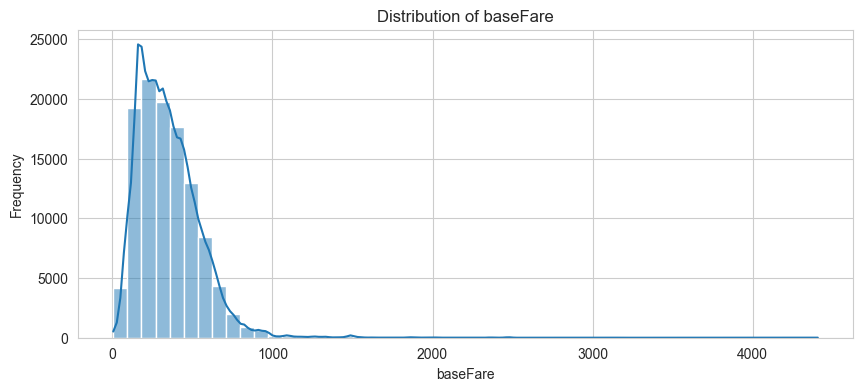

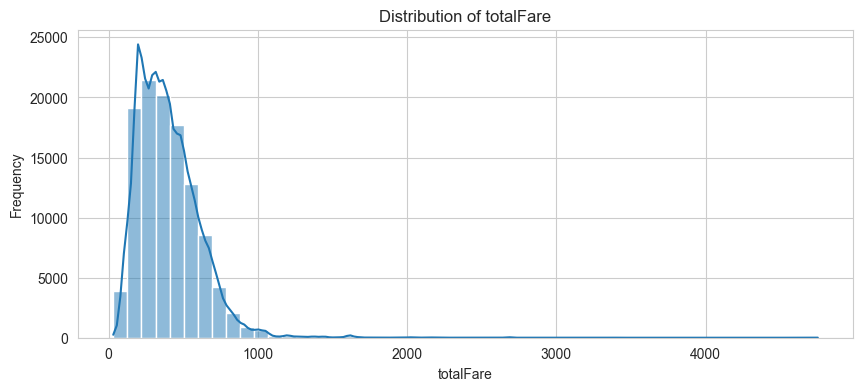

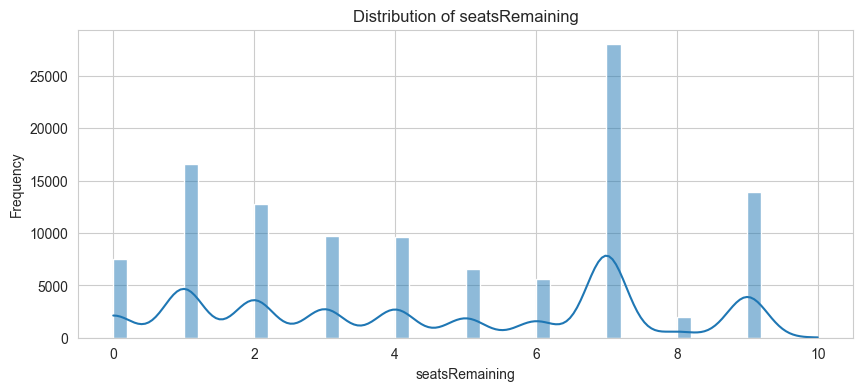

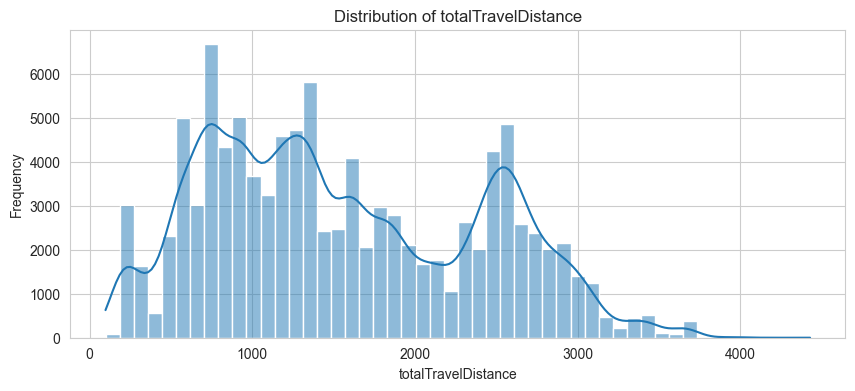

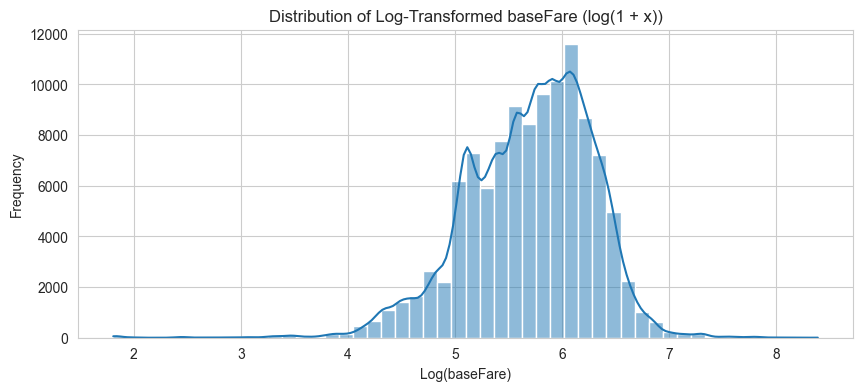


--- 2. Boolean Column Distributions ---


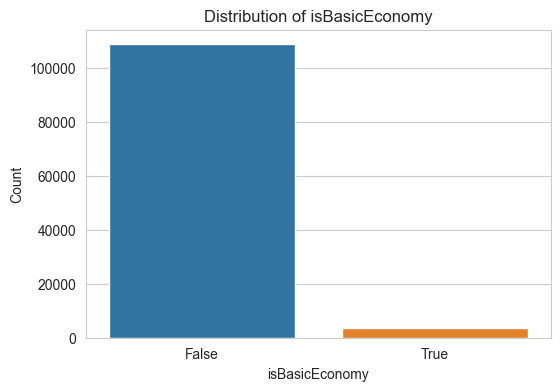

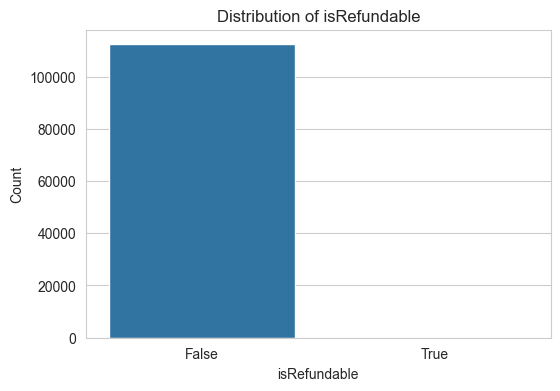

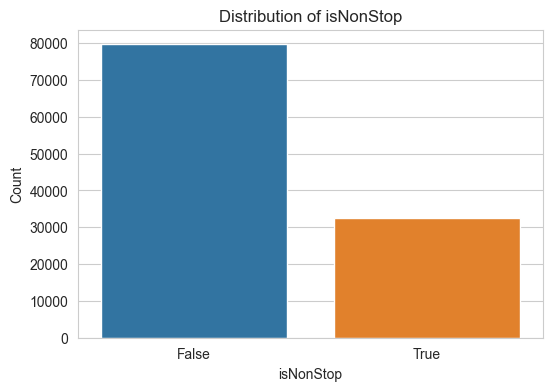


--- 3. Low-Cardinality Categorical Distributions ---


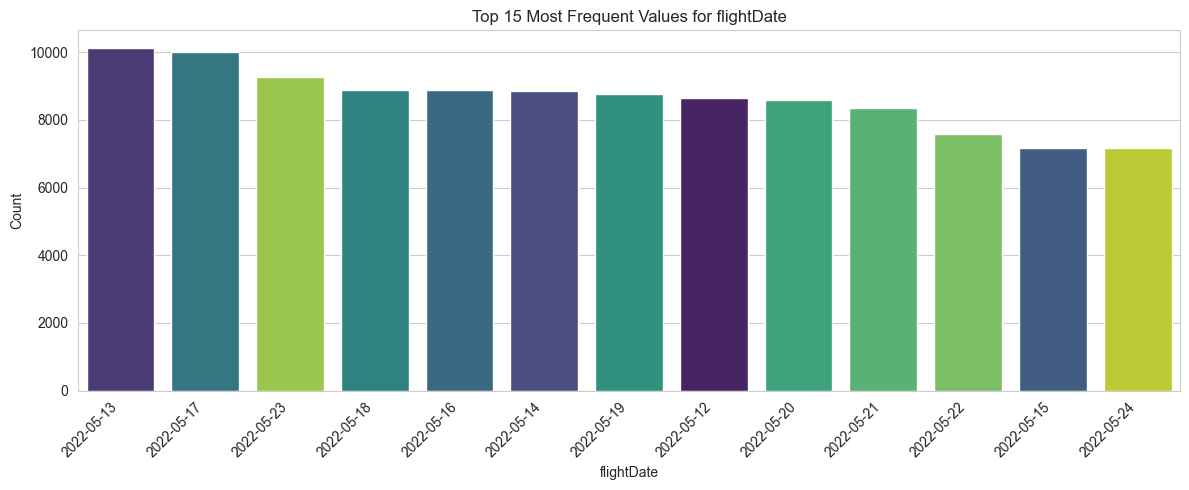

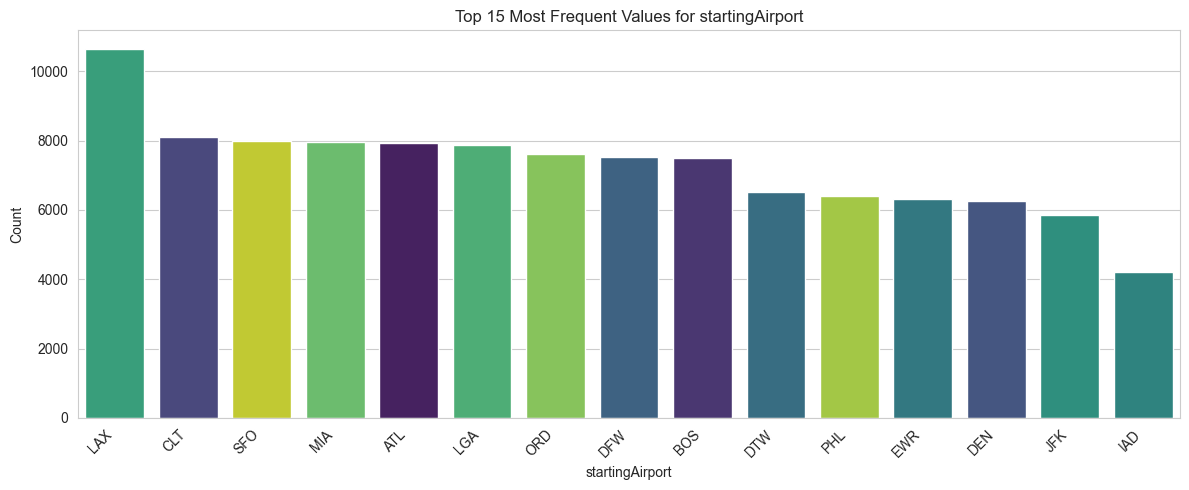

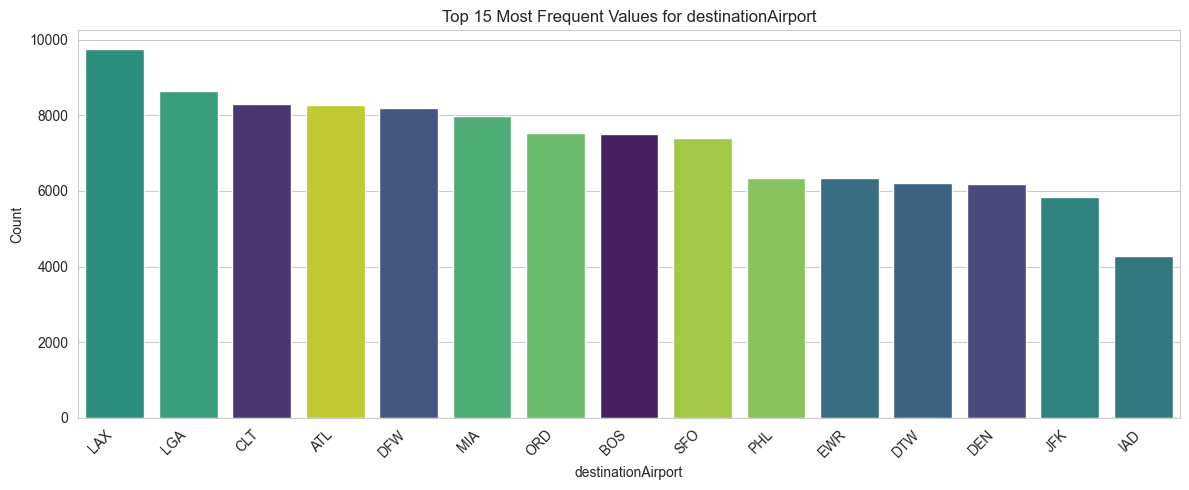

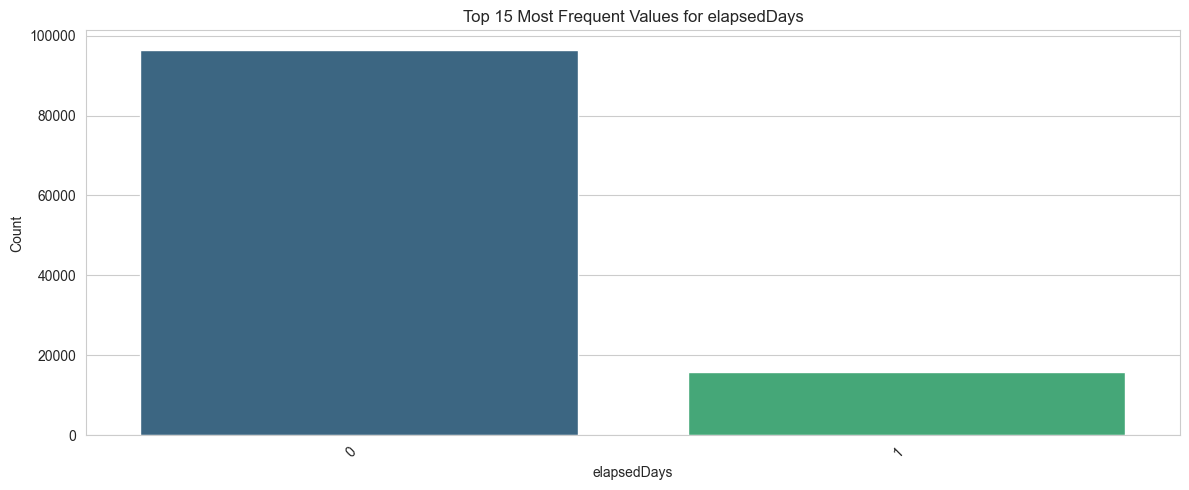

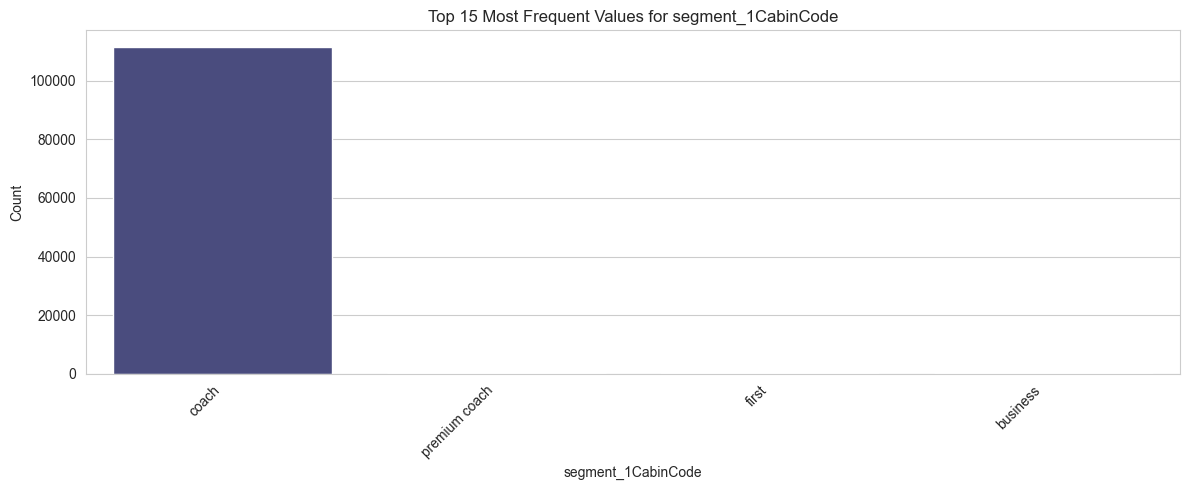

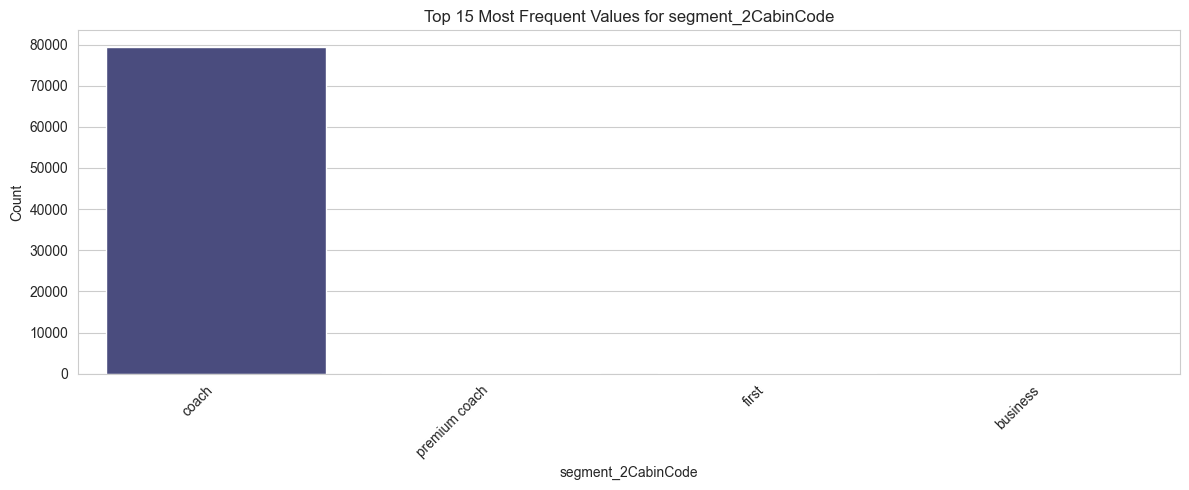

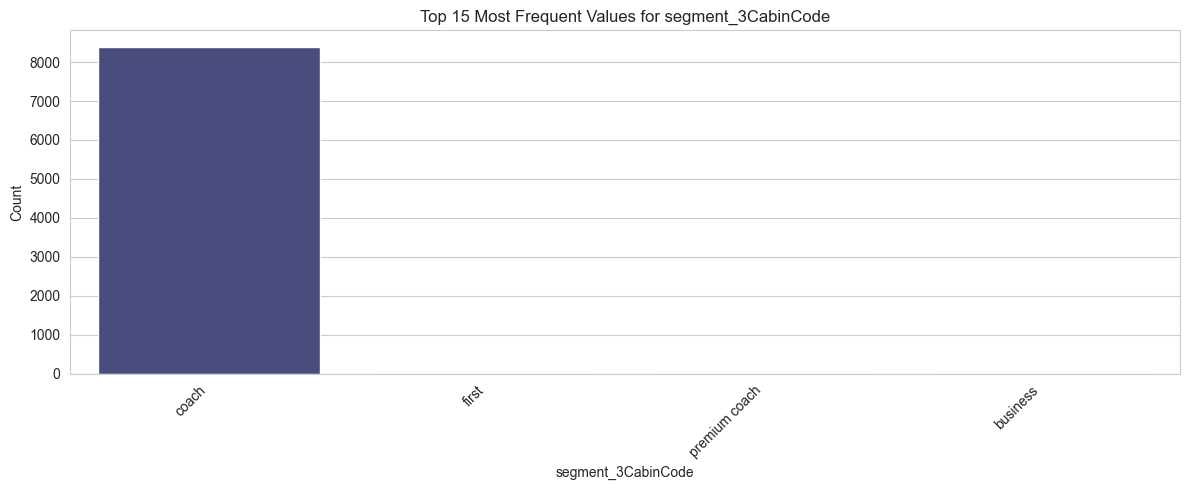

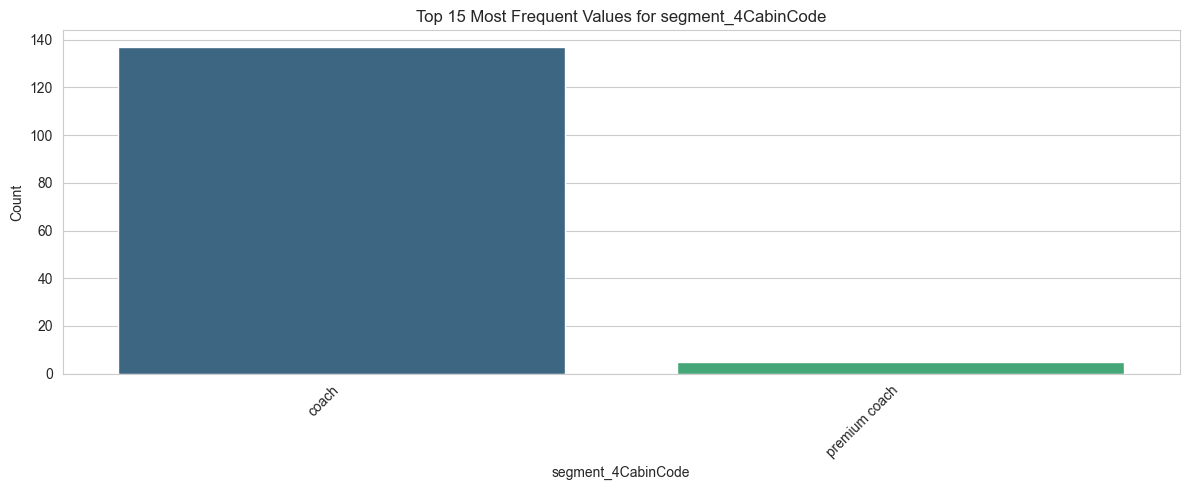


--- 4. High-Cardinality & Identifier Columns (Summary) ---


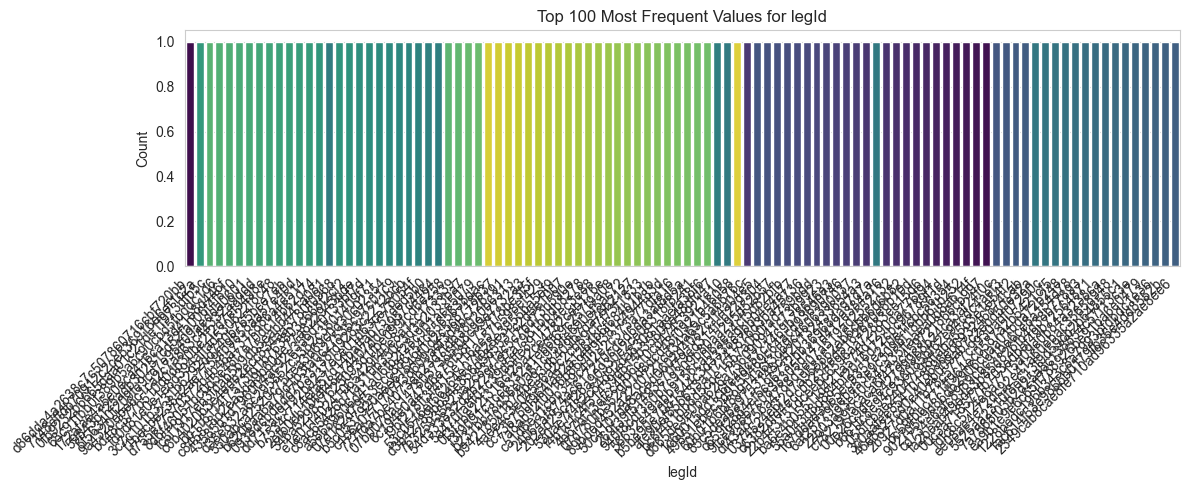

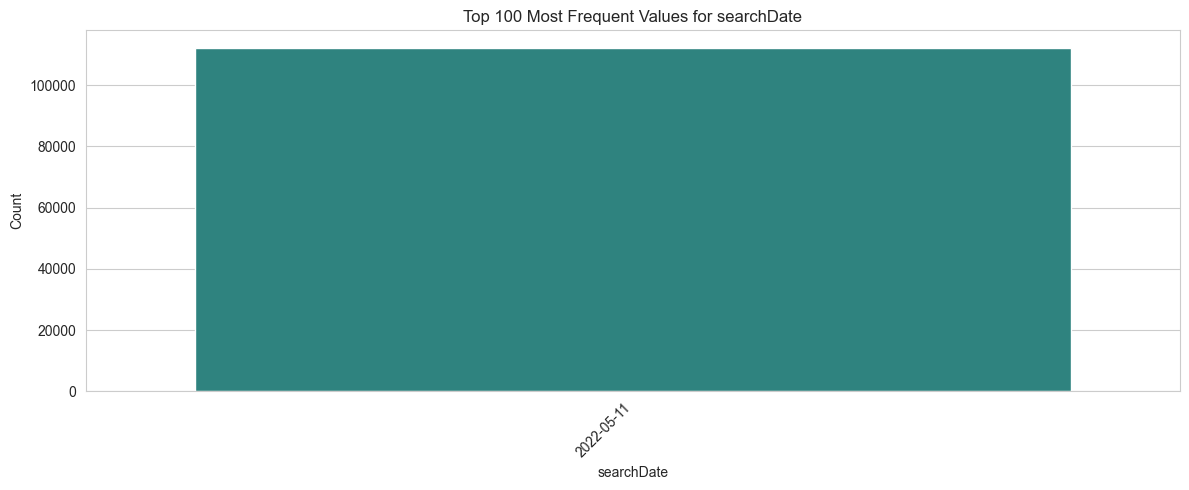

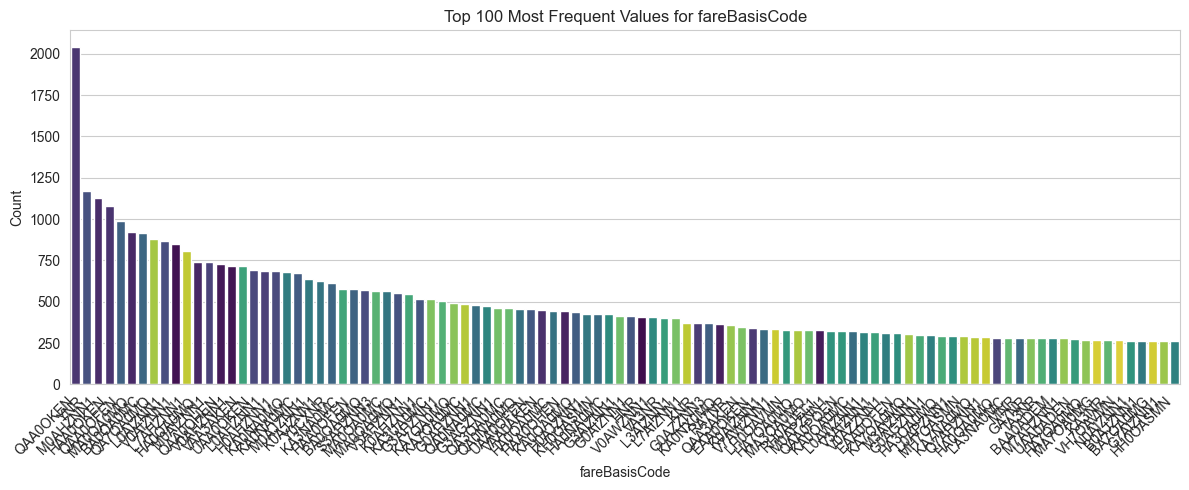

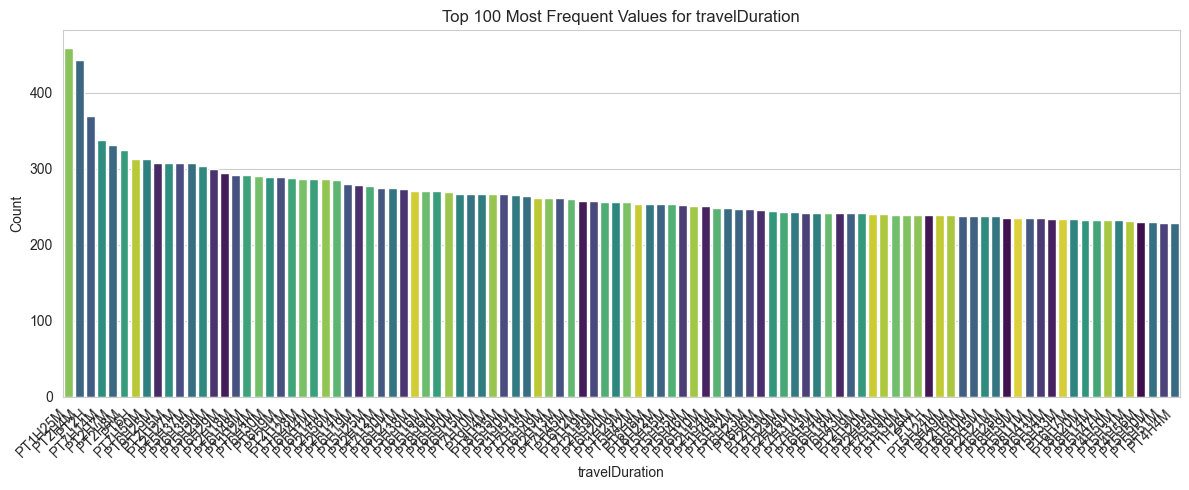

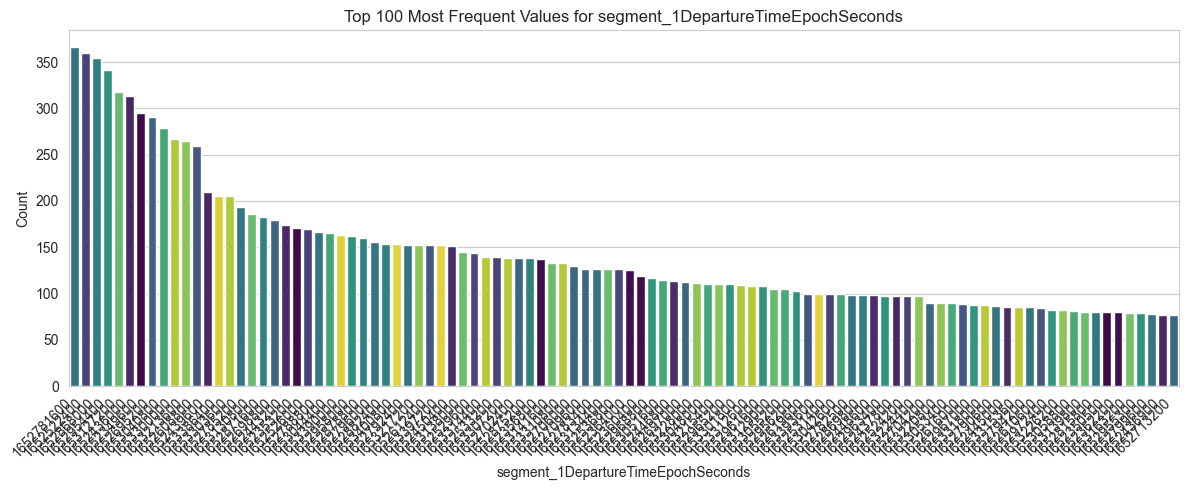

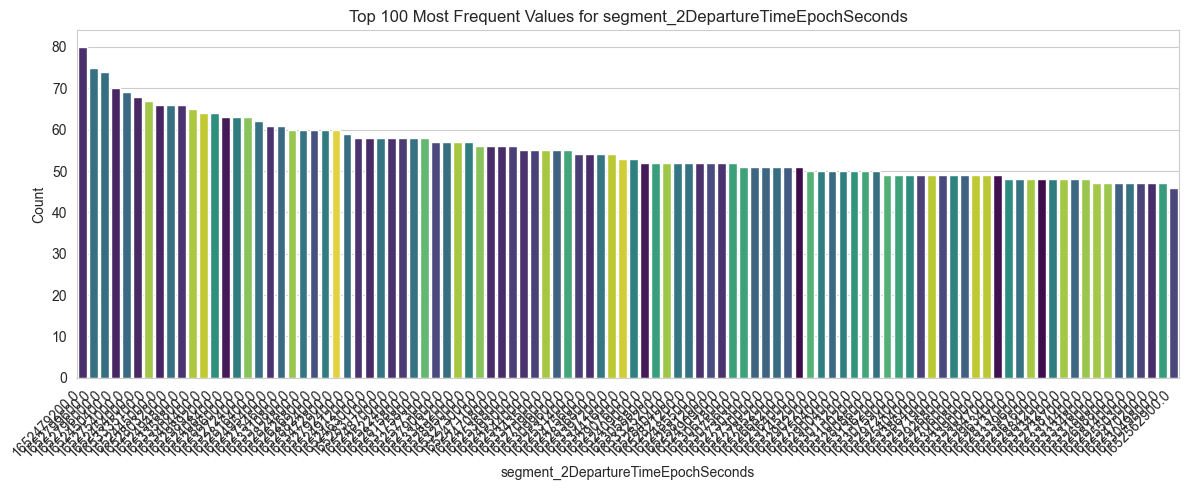

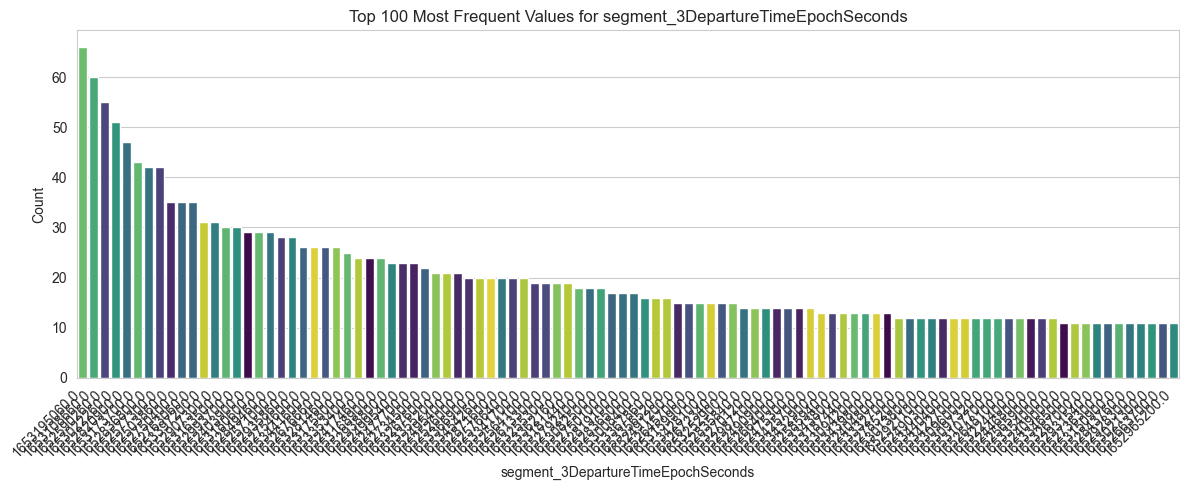

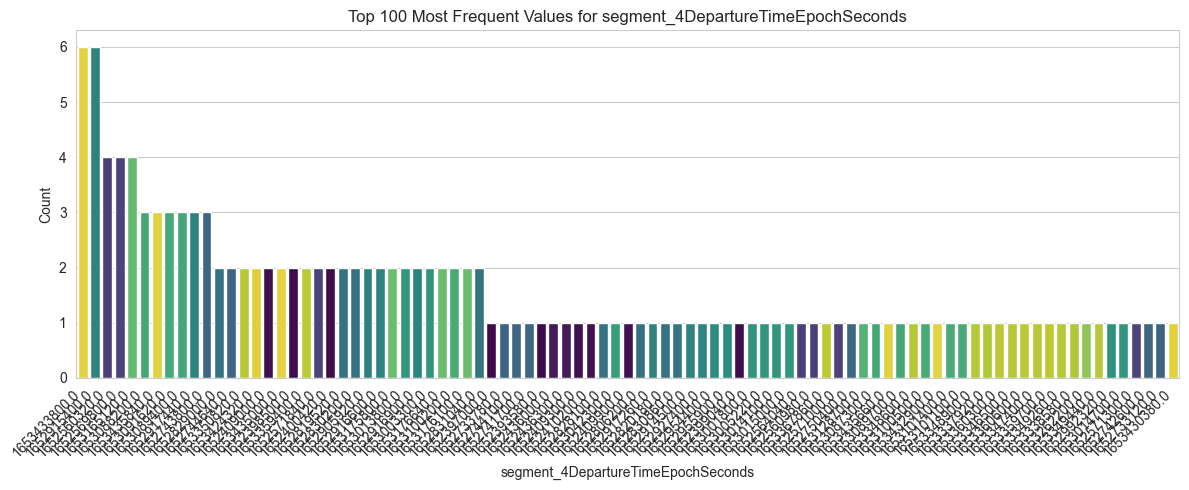

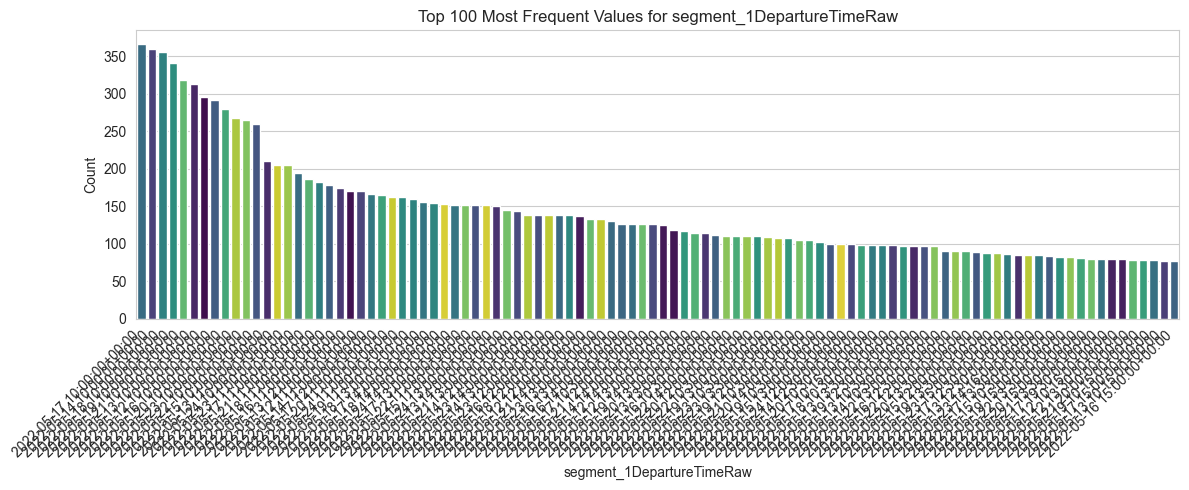

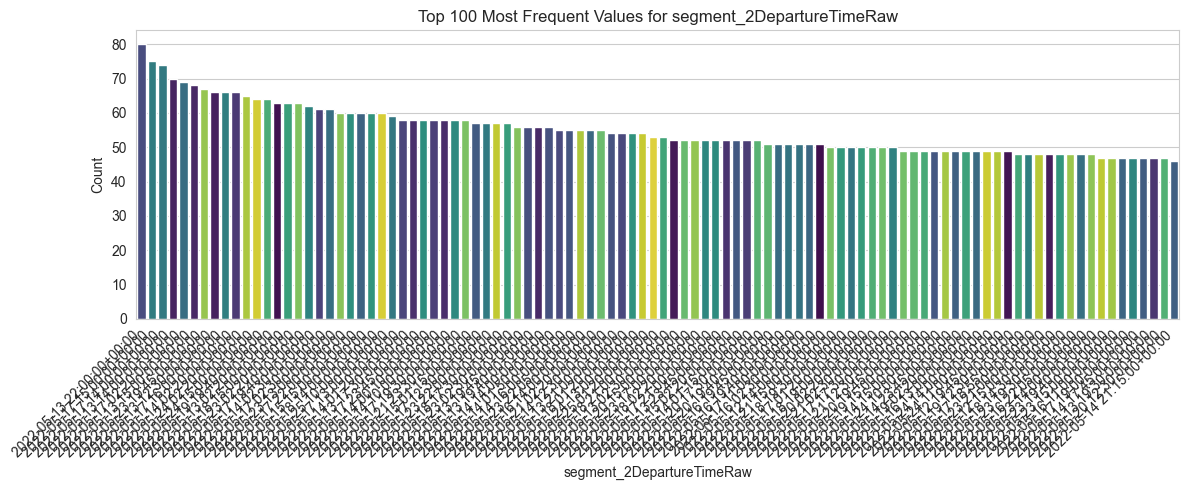

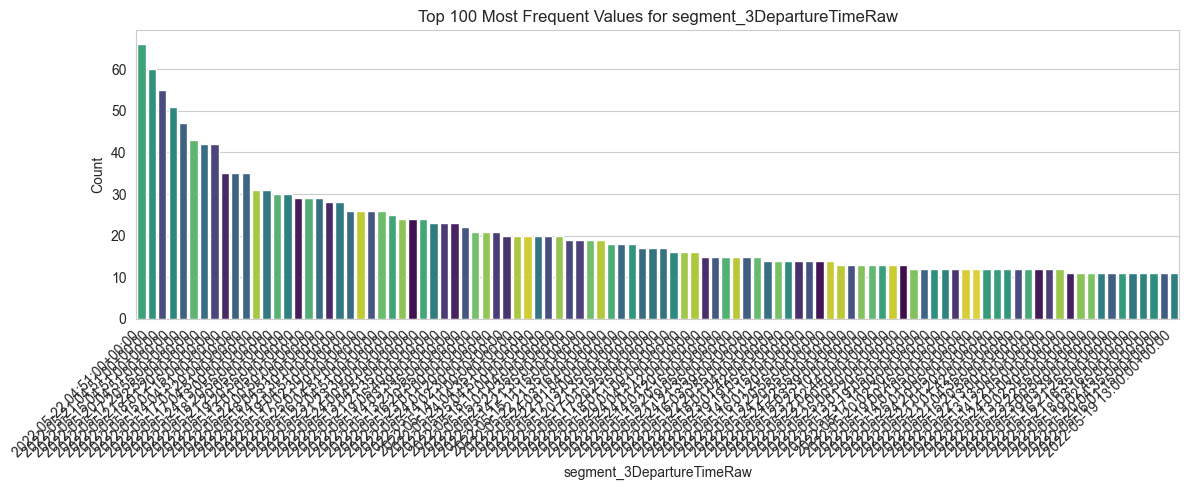

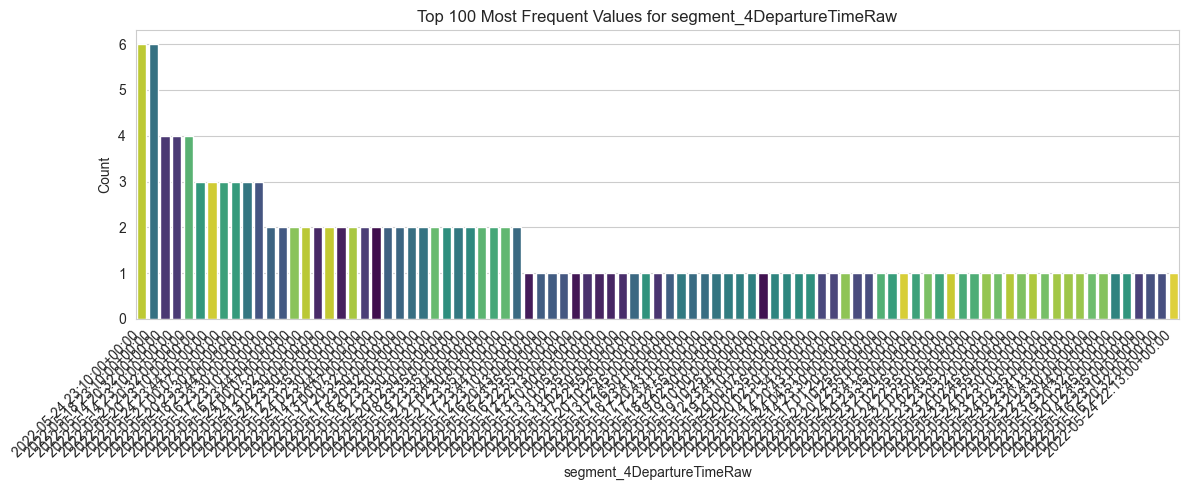

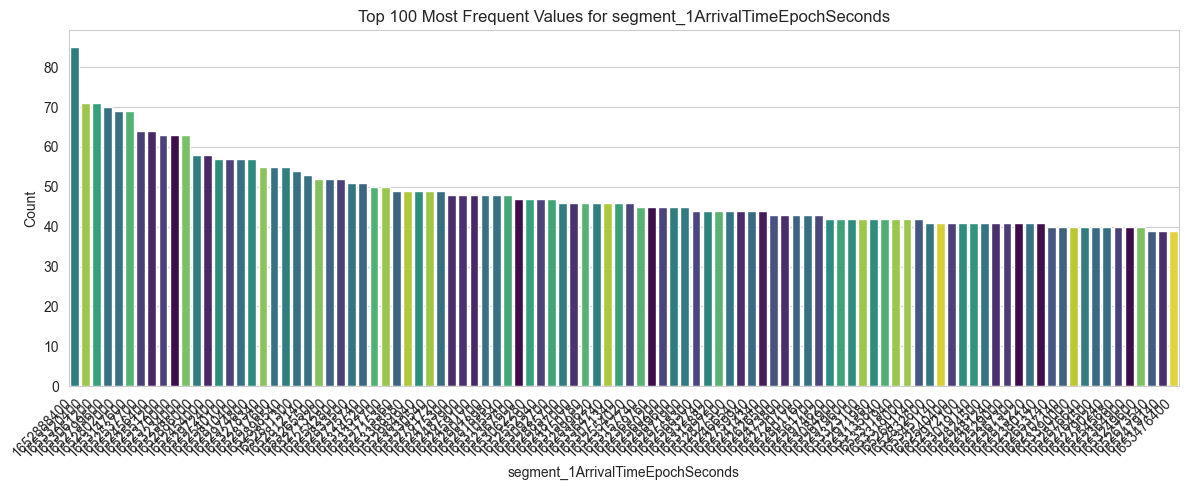

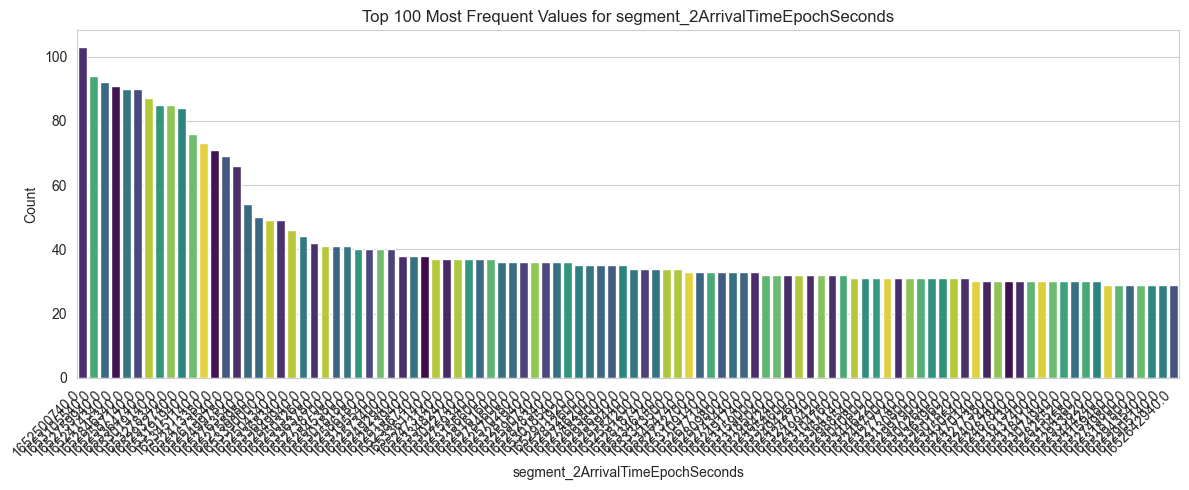

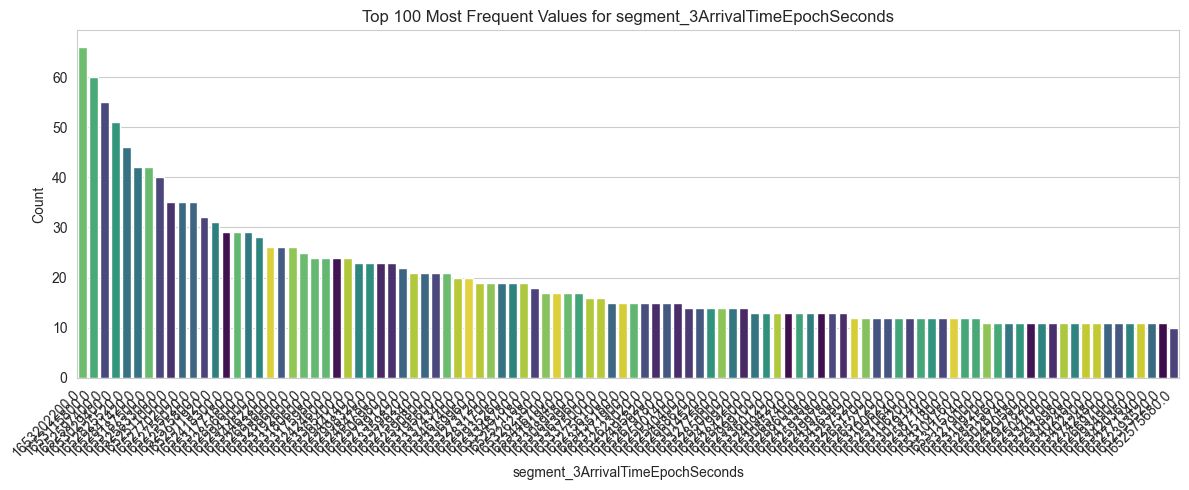

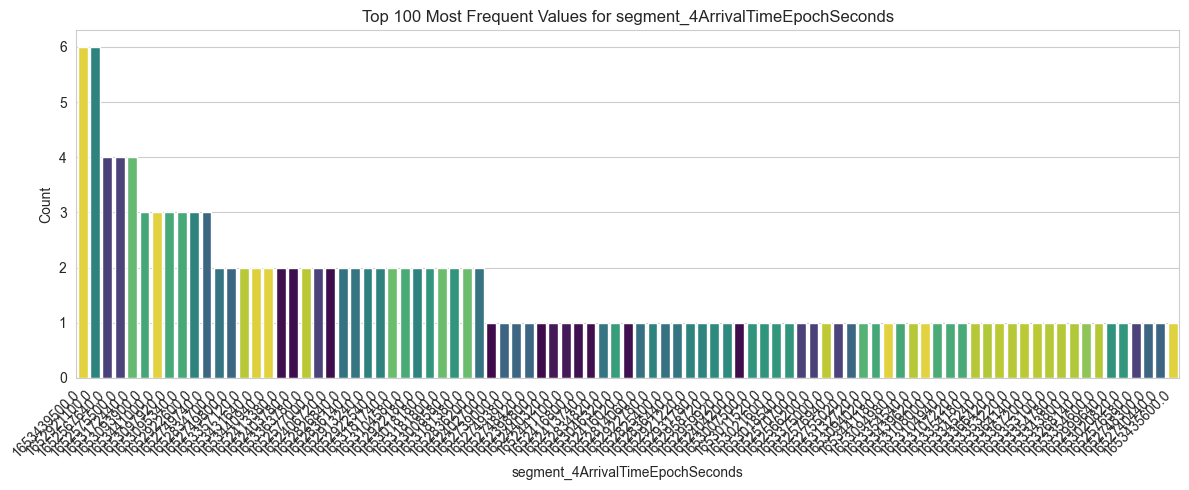

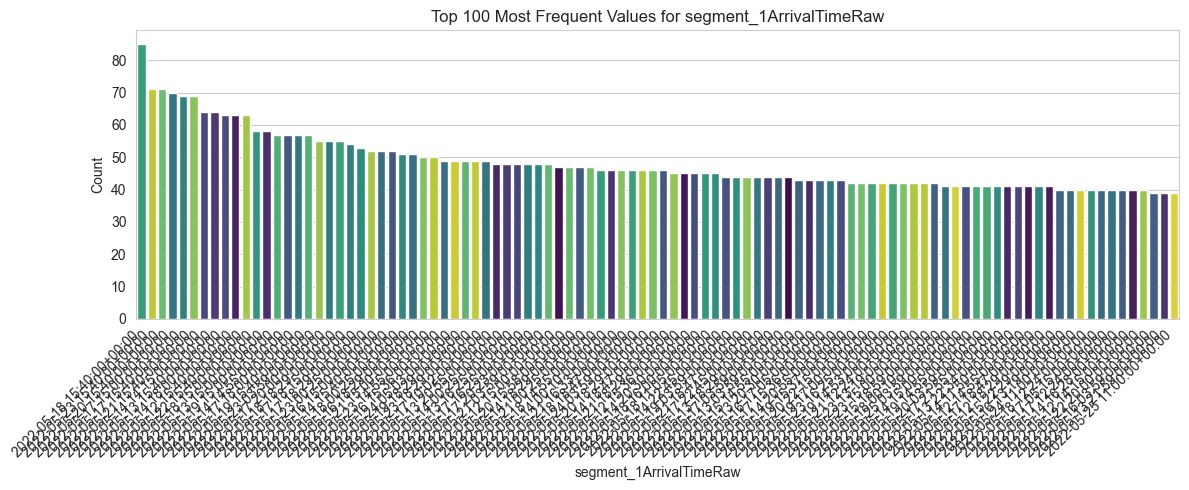

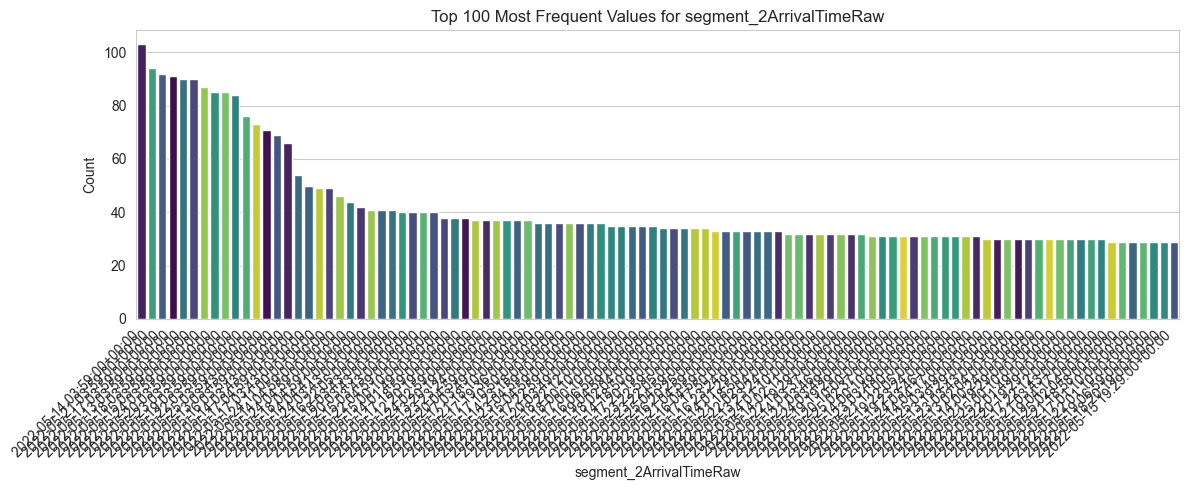

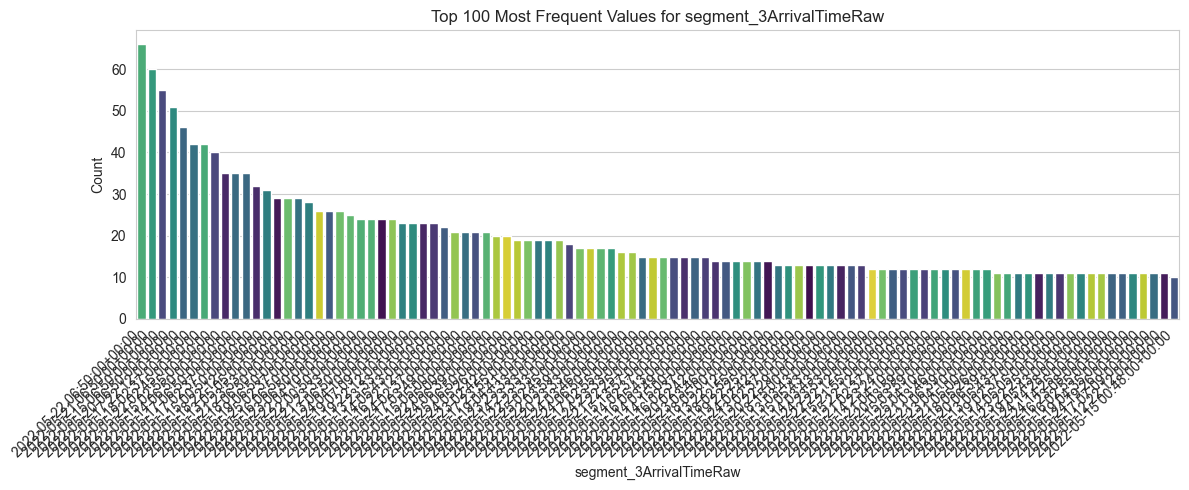

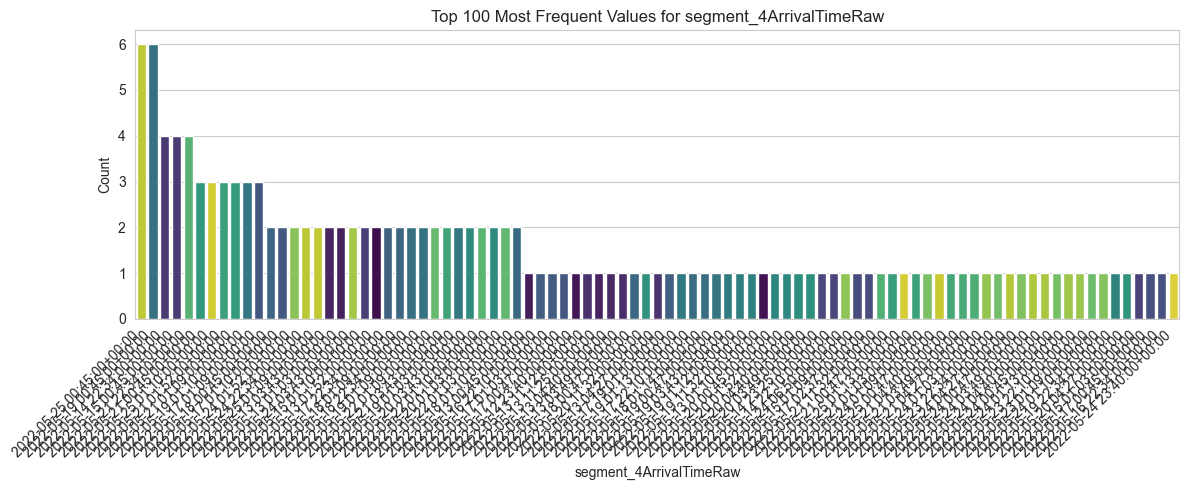

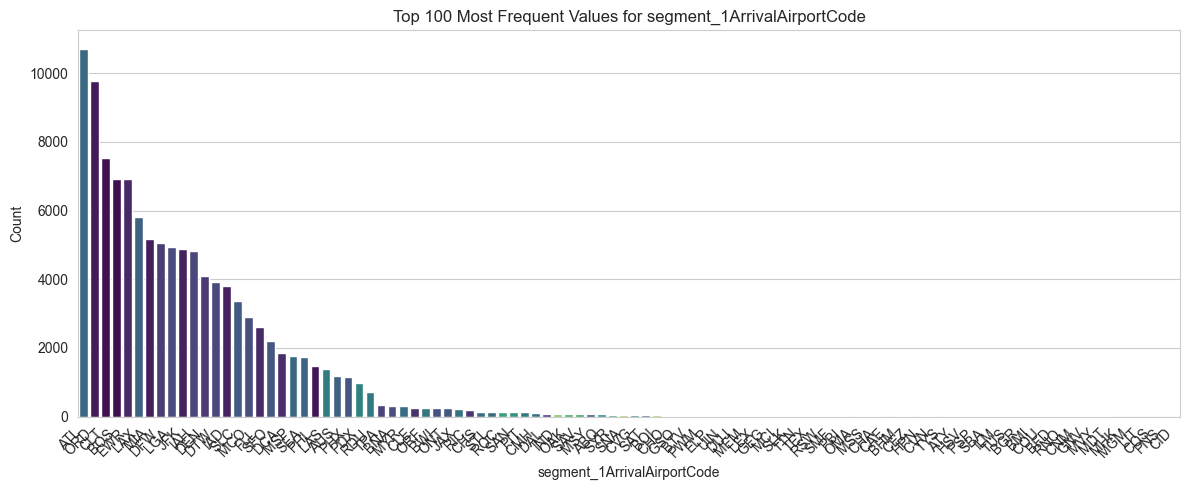

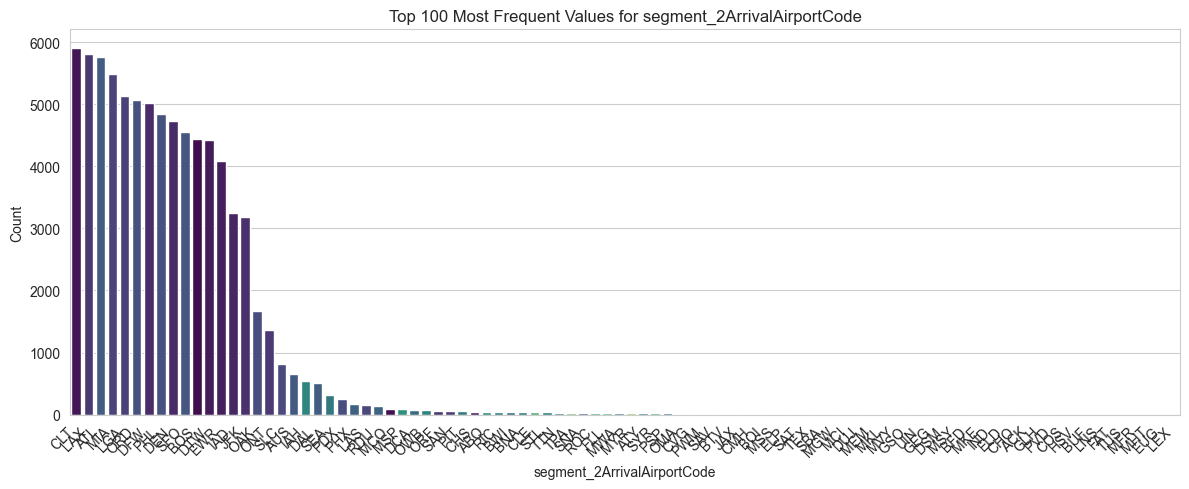

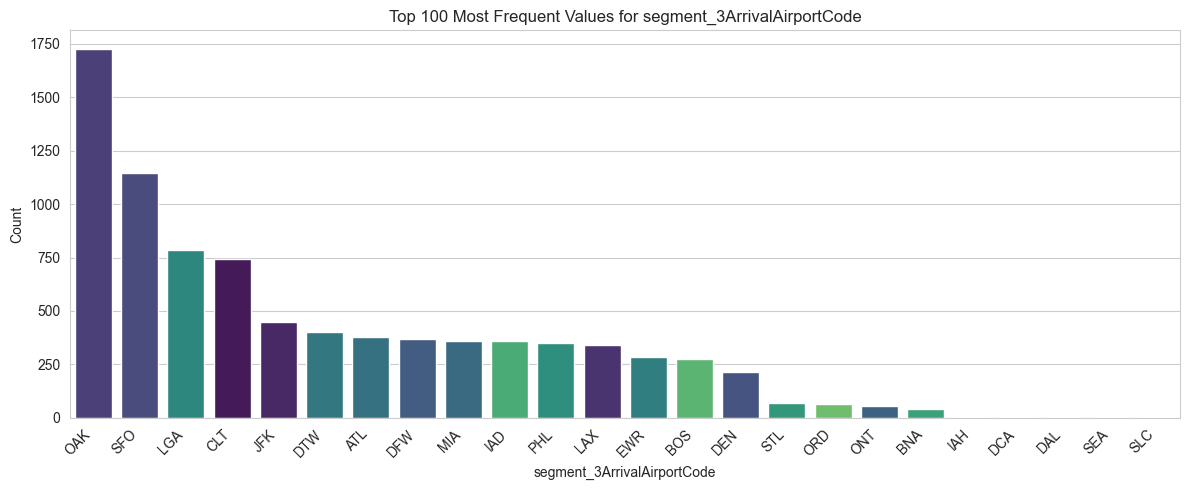

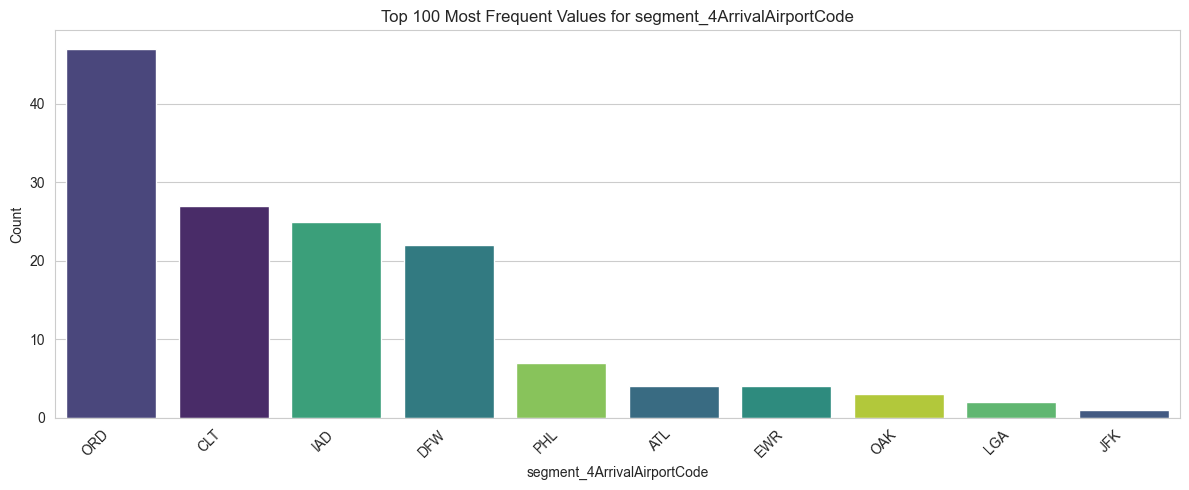

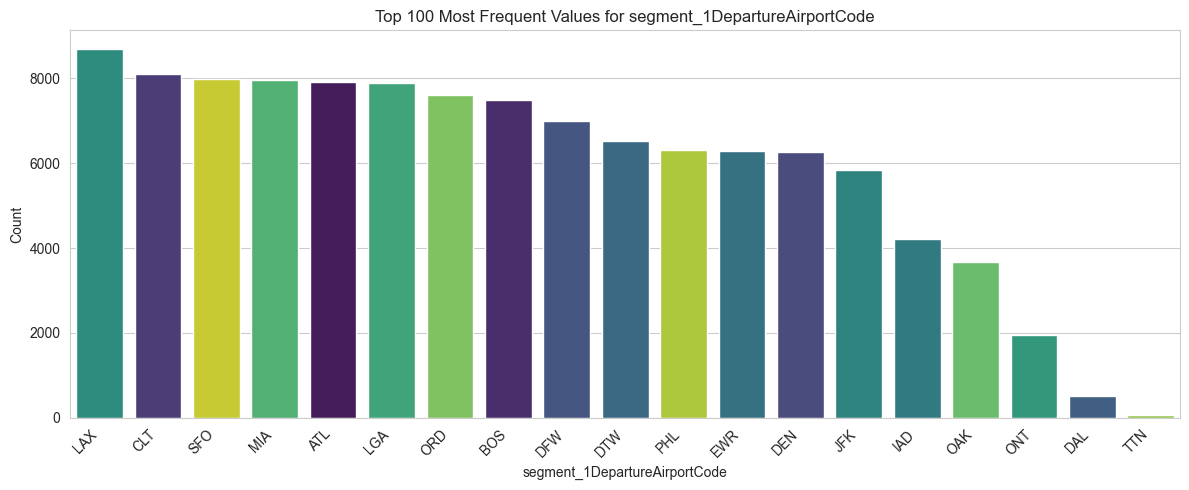

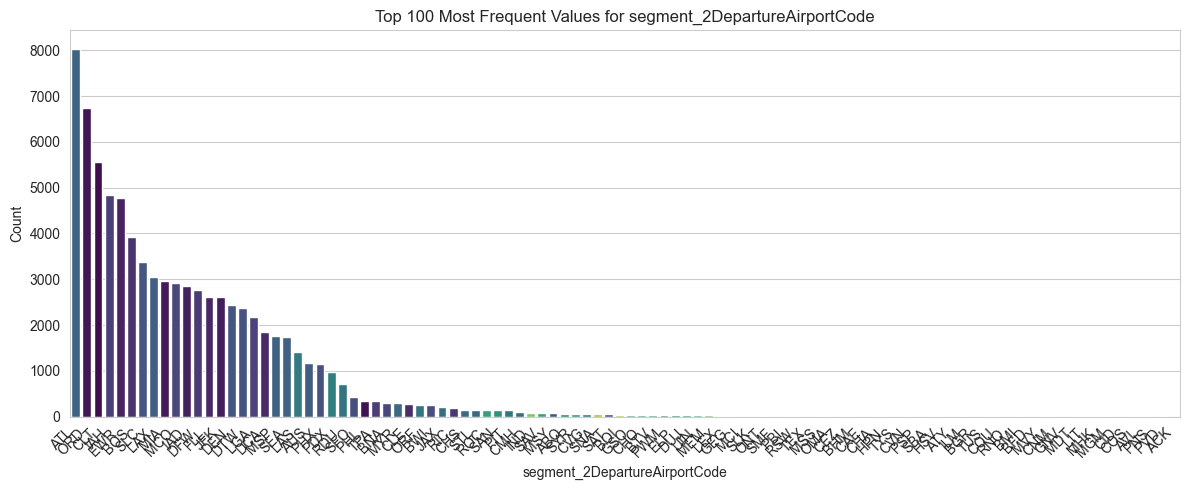

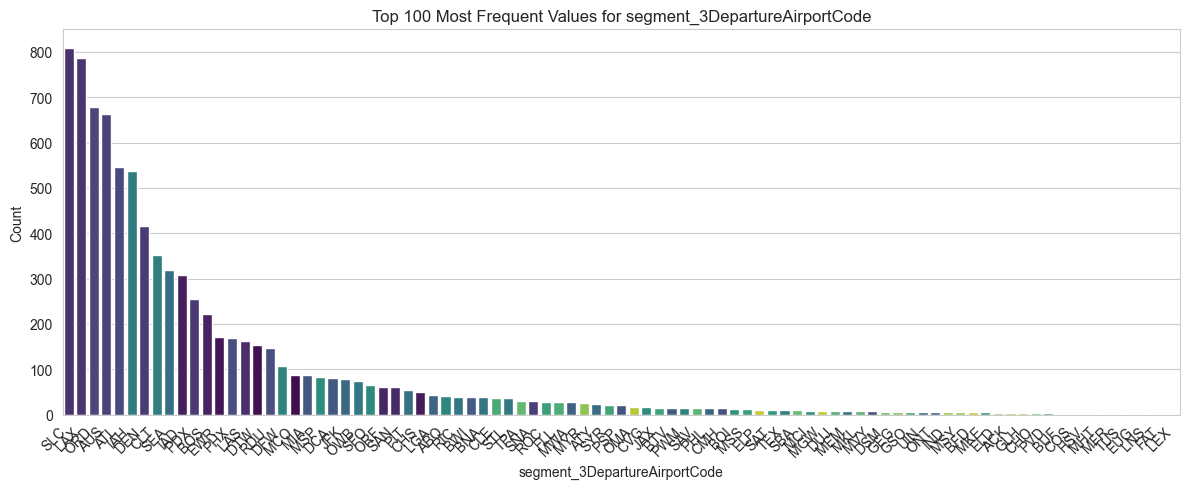

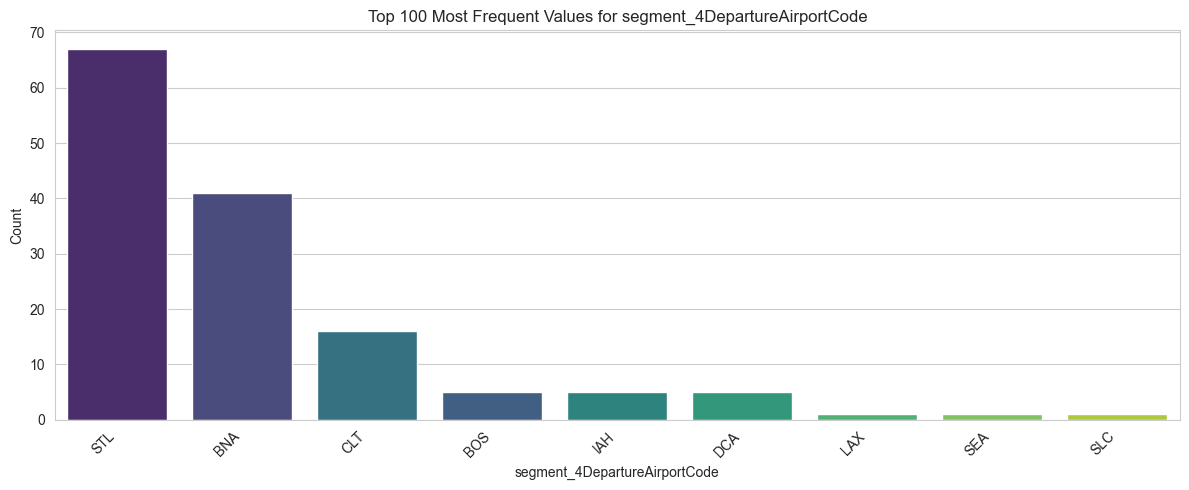

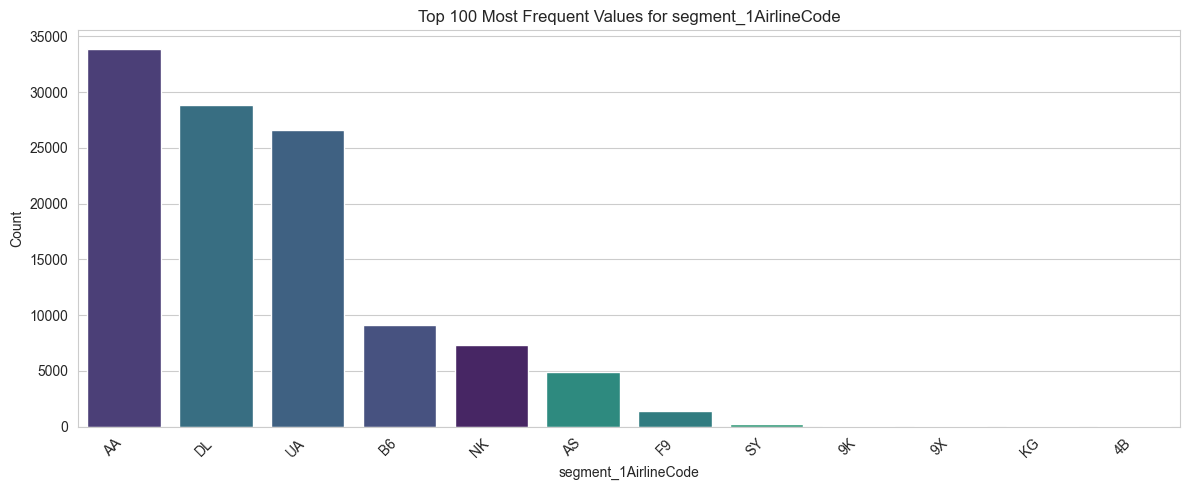

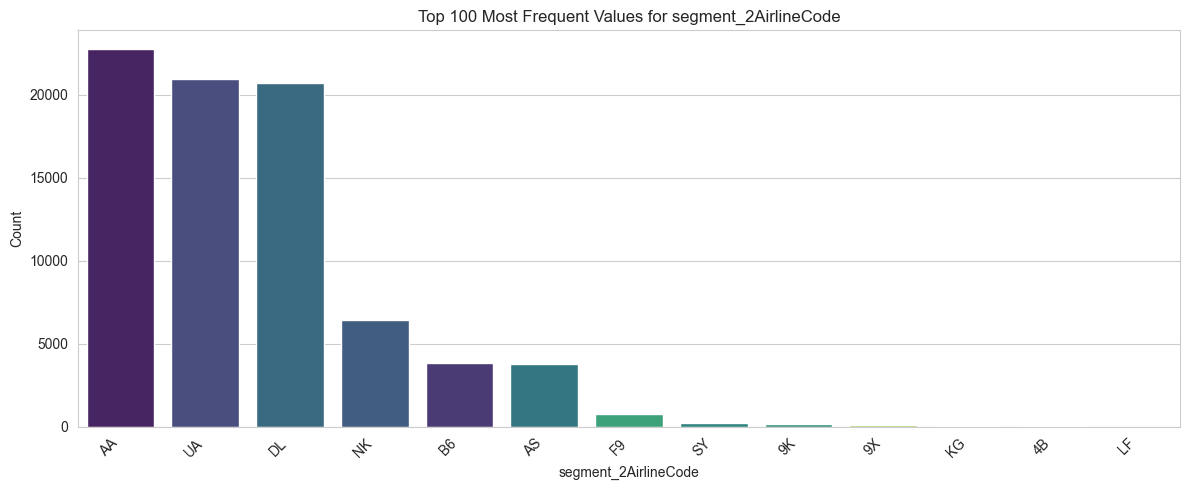

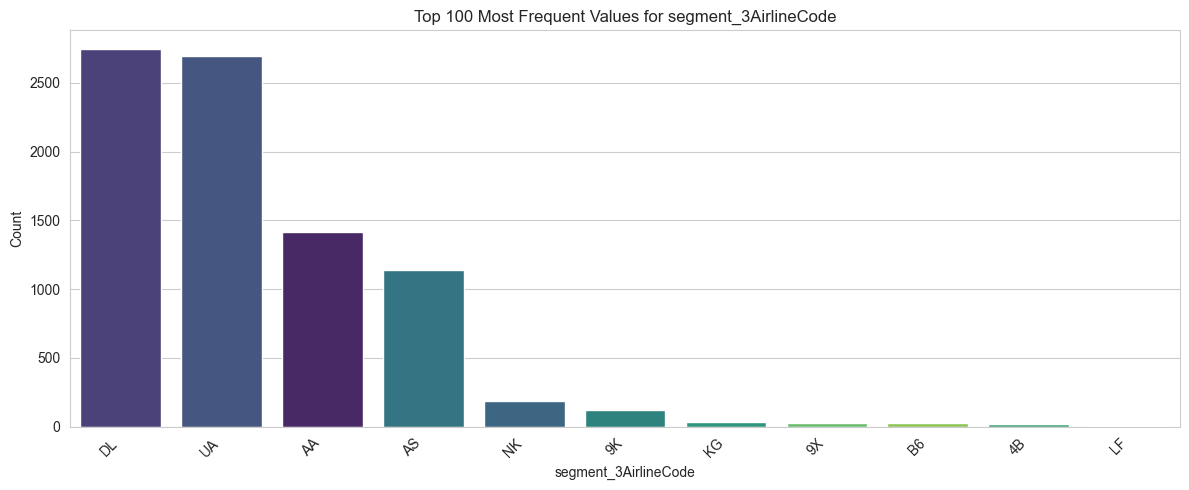

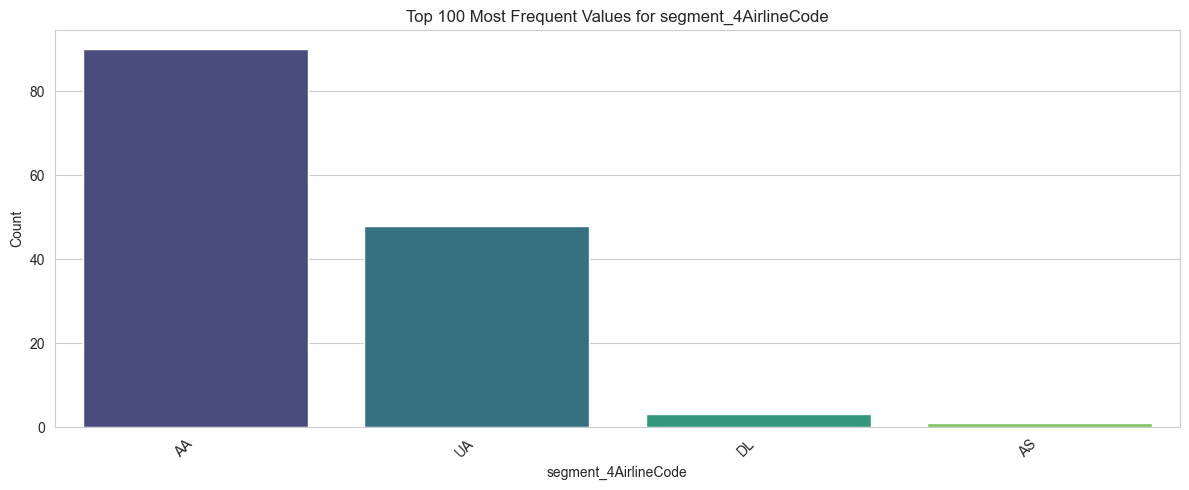

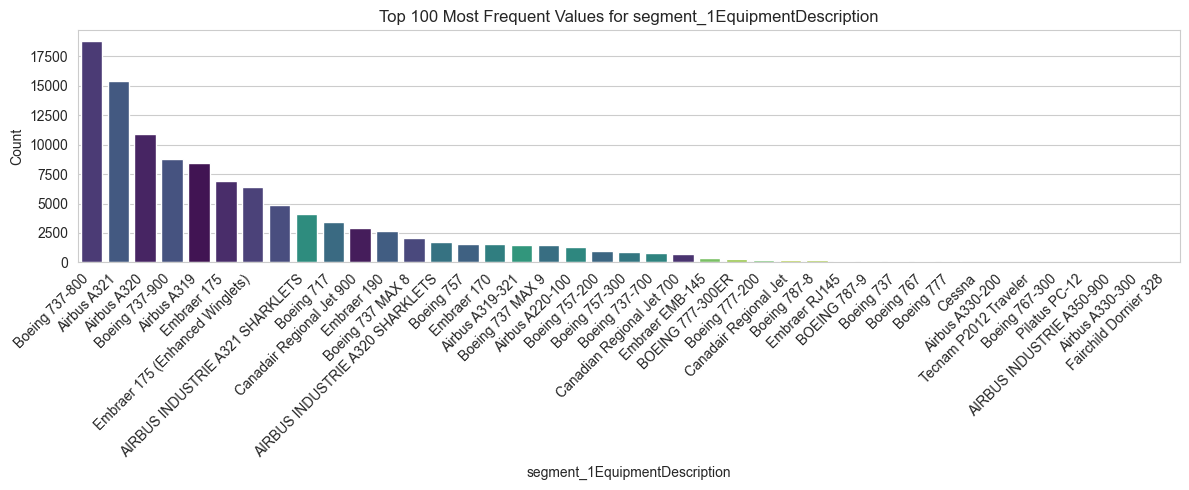

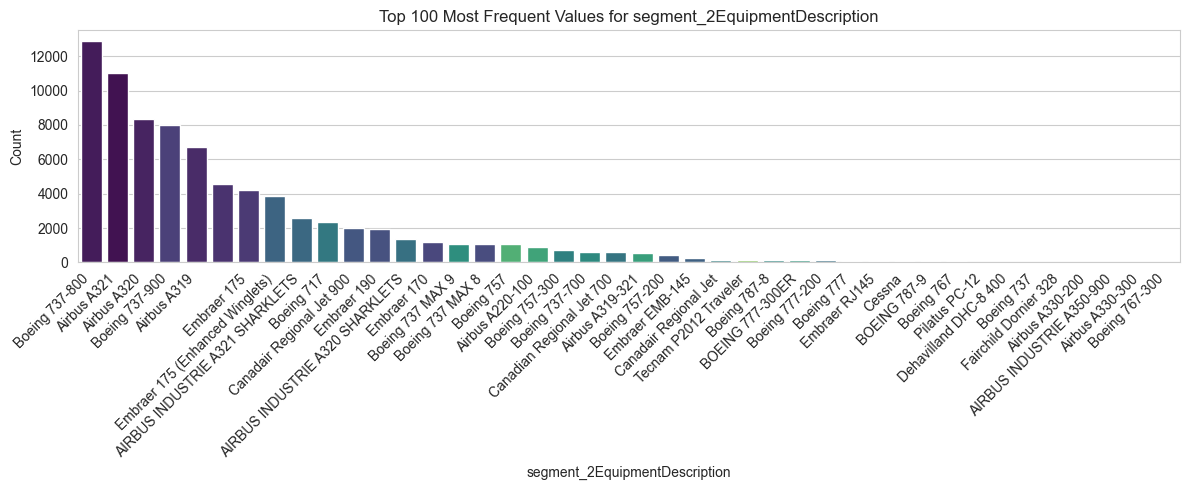

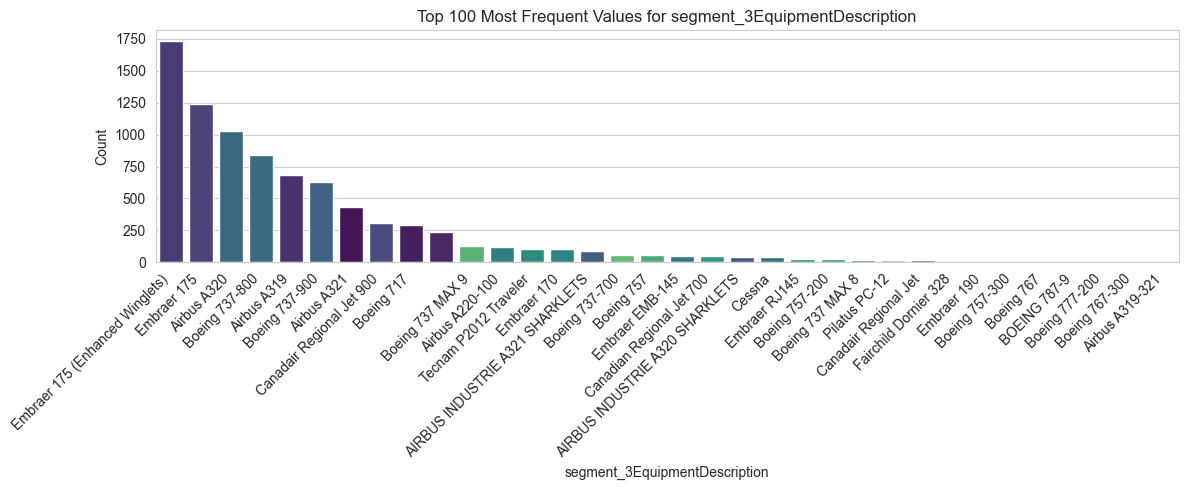

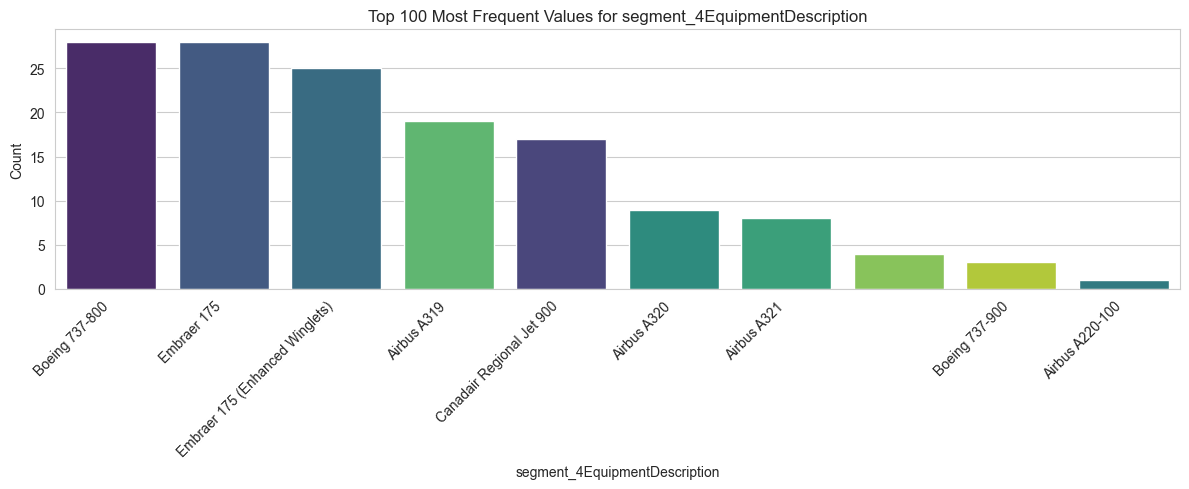

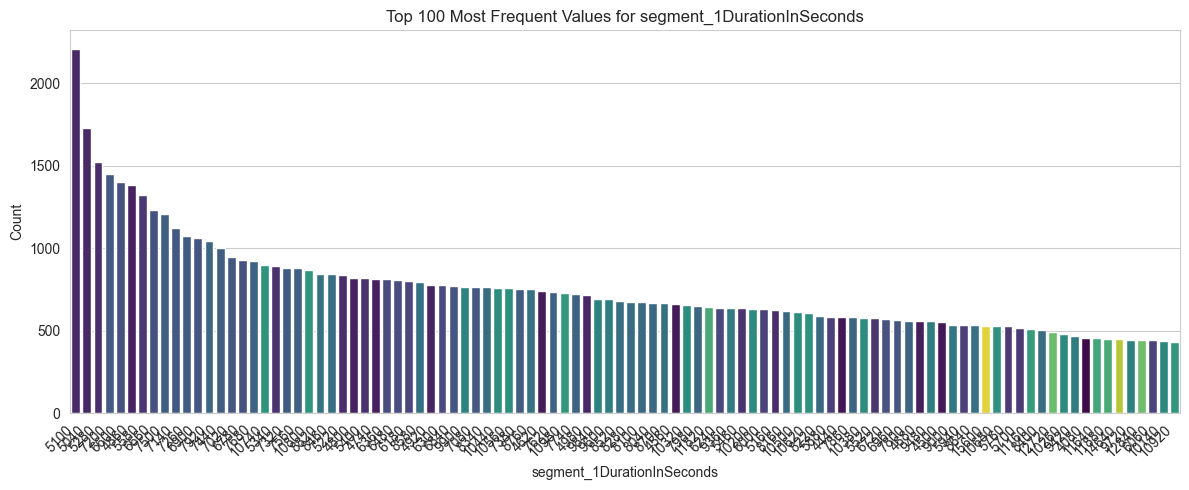

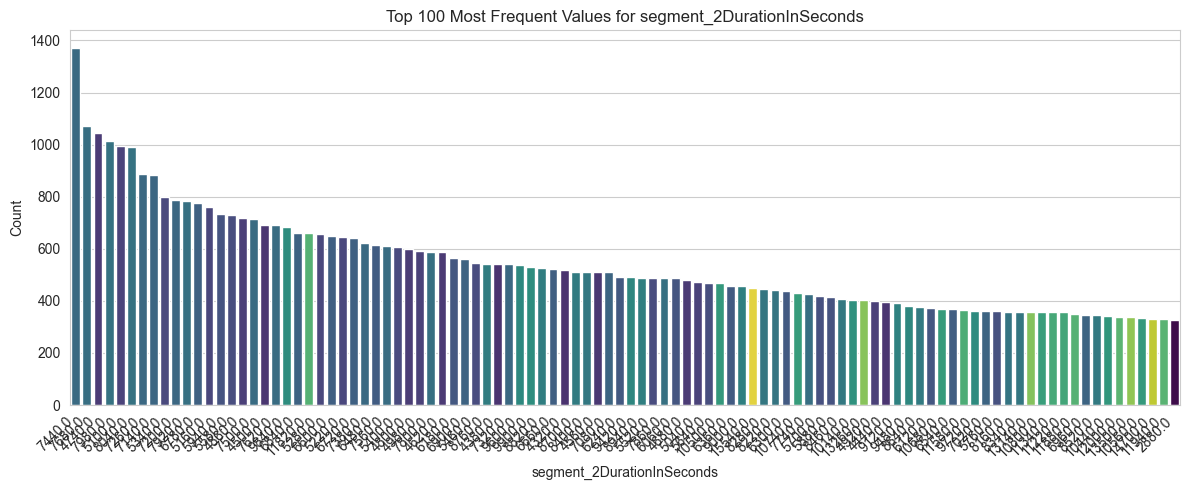

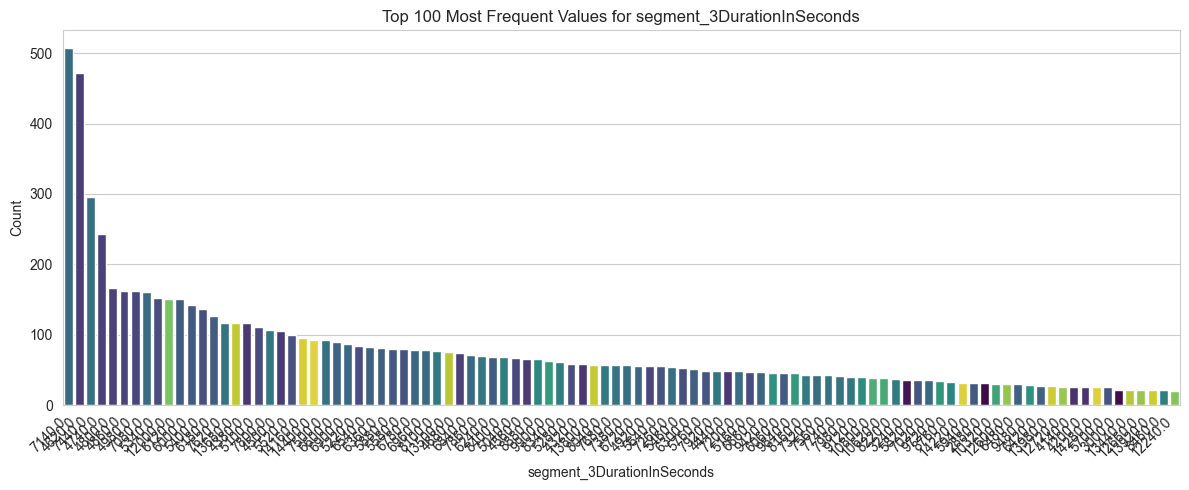

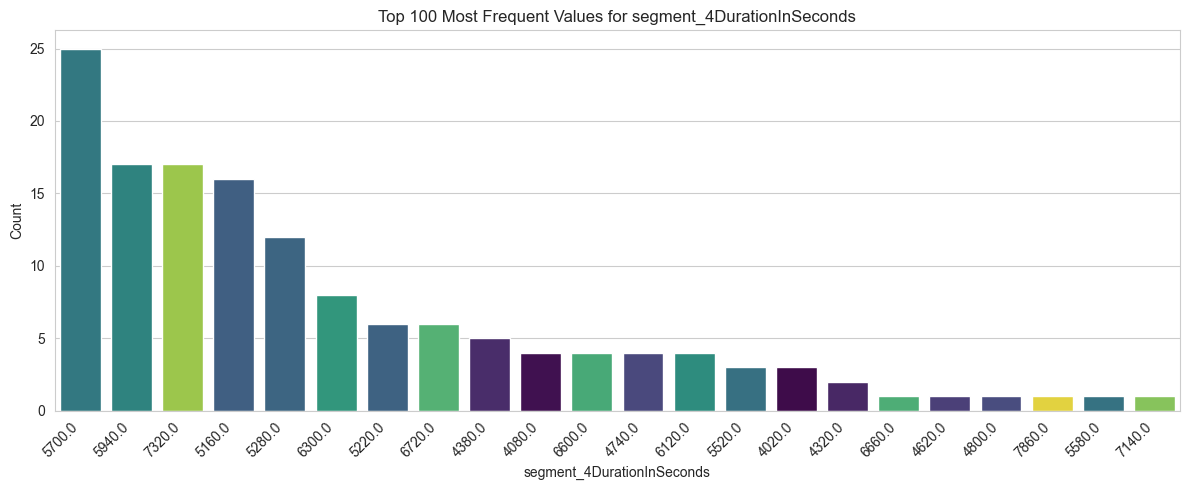

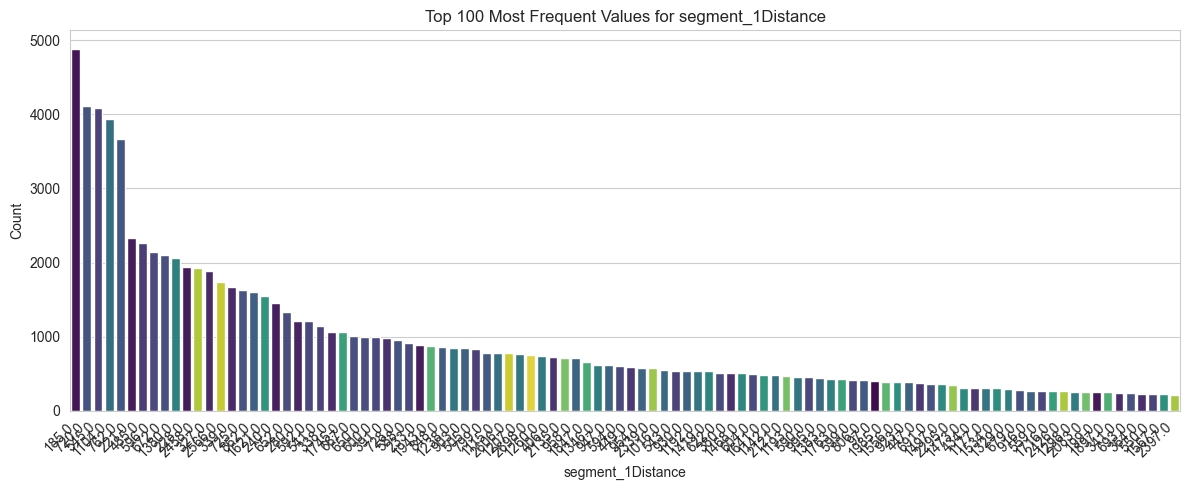

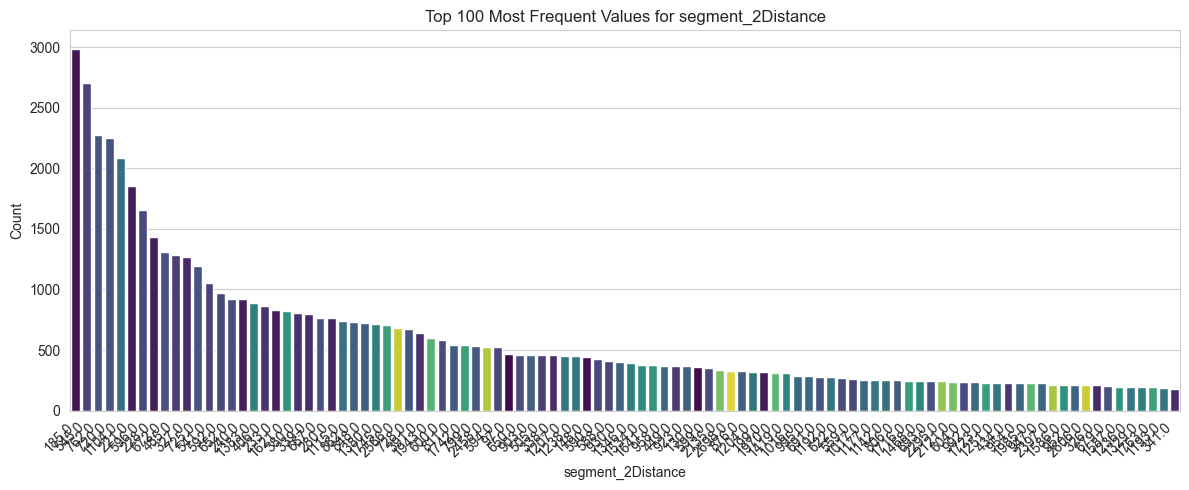

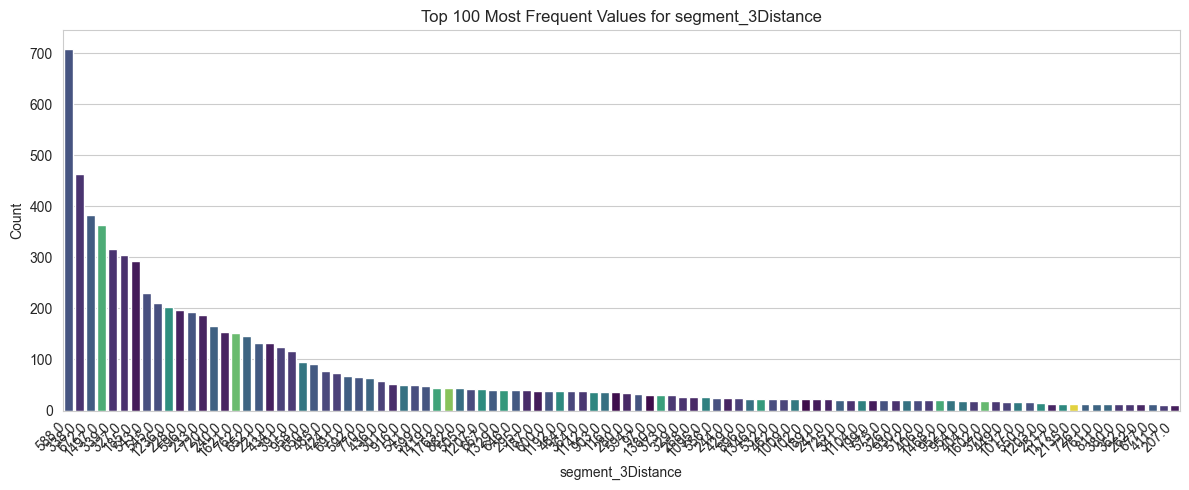

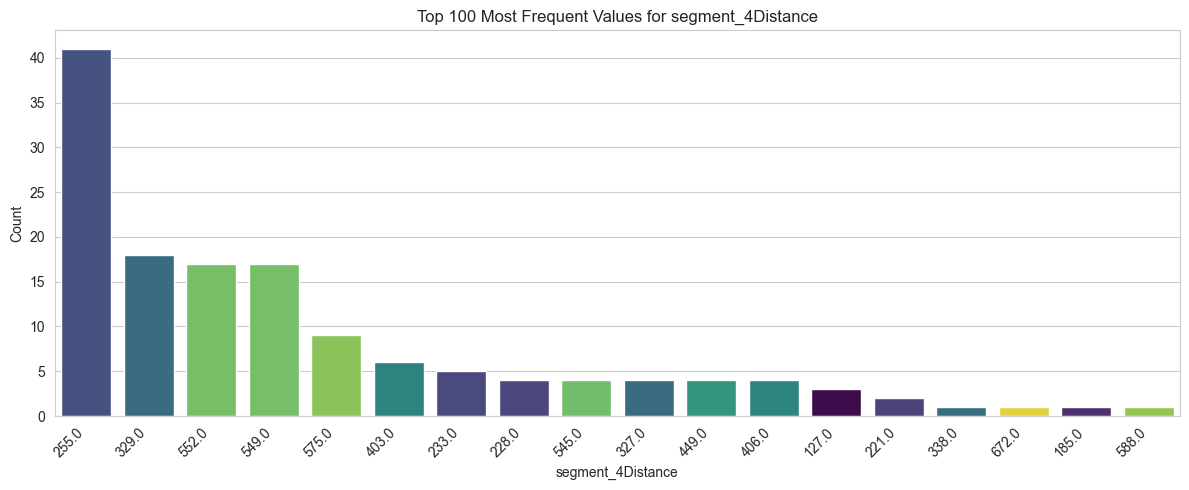


--- Distribution analysis complete ---


In [12]:
# 1. Calculate and print missing value percentages
print("--- Missing Value Percentages ---")
print(f"All columns: {data.columns}")
missing_percent = (data.isnull().sum() / len(data)) * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))
print("\n")


# Set up a plotting style
sns.set_style("whitegrid")
print("--- Analyzing Column Distributions ---")

# ==============================================================================
# 1. Numerical Columns
# ==============================================================================
print("\n--- 1. Numerical Column Distributions ---")
num_cols = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']

# Plotting histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show() # Show plot

# Also plot log-transformed version for skewed currency data
plt.figure(figsize=(10, 4))
sns.histplot(np.log1p(data['baseFare']), kde=True, bins=50)
plt.title('Distribution of Log-Transformed baseFare (log(1 + x))')
plt.xlabel('Log(baseFare)')
plt.ylabel('Frequency')
plt.show() # Show plot


# ==============================================================================
# 2. Boolean Columns
# ==============================================================================
print("\n--- 2. Boolean Column Distributions ---")
bool_cols = ['isBasicEconomy', 'isRefundable', 'isNonStop']

for col in bool_cols:
    plt.figure(figsize=(6, 4))
    # --- Fix for FutureWarning ---
    sns.countplot(
        data=data,
        x=col,
        hue=col,       # Assign x to hue
        legend=False   # Disable legend
    )
    # --- End of Fix ---
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show() # Show plot

# ==============================================================================
# 3. Low-Cardinality Categorical Columns
# ==============================================================================
print("\n--- 3. Low-Cardinality Categorical Distributions ---")

# A helper function to plot top N categories
def plot_top_n(column_name, n=15):
    plt.figure(figsize=(12, 5))
    
    # Get top N value counts
    top_n = data[column_name].value_counts().nlargest(n).index
    
    # Filter data to only include top N for plotting
    data_to_plot = data[data[column_name].isin(top_n)]
    
    # --- Fix for FutureWarning ---
    sns.countplot(
        data=data_to_plot,          # Pass the filtered dataframe
        x=column_name,              # Pass the column name as a string
        order=top_n,                # Keep the order
        hue=column_name,            # Assign the column name to hue
        palette="viridis",
        legend=False                # Disable the legend as suggested
    )
    # --- End of Fix ---
    
    plt.title(f'Top {n} Most Frequent Values for {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show() # Show plot
    
# Columns to plot
low_card_cols = [
    'flightDate',
    'startingAirport',
    'destinationAirport',
    'elapsedDays', # Treating as categorical since it's just 0 or 1
    'segment_1CabinCode',
    'segment_2CabinCode',
    'segment_3CabinCode',
    'segment_4CabinCode'
]

for col in low_card_cols:
    plot_top_n(col, n=15)


# ==============================================================================
# 4. High-Cardinality & Identifier Columns
# ==============================================================================
print("\n--- 4. High-Cardinality & Identifier Columns (Summary) ---")
# These columns are not suitable for plotting. We'll print their unique counts
# and the top 5 most frequent values.

high_card_cols = [
    'legId',
    'searchDate',
    'fareBasisCode',
    'travelDuration',
    'segment_1DepartureTimeEpochSeconds',
    'segment_2DepartureTimeEpochSeconds',
    'segment_3DepartureTimeEpochSeconds',
    'segment_4DepartureTimeEpochSeconds',
    'segment_1DepartureTimeRaw',
    'segment_2DepartureTimeRaw',
    'segment_3DepartureTimeRaw',
    'segment_4DepartureTimeRaw',
    'segment_1ArrivalTimeEpochSeconds',
    'segment_2ArrivalTimeEpochSeconds',
    'segment_3ArrivalTimeEpochSeconds',
    'segment_4ArrivalTimeEpochSeconds',
    'segment_1ArrivalTimeRaw',
    'segment_2ArrivalTimeRaw',
    'segment_3ArrivalTimeRaw',
    'segment_4ArrivalTimeRaw',
    'segment_1ArrivalAirportCode',
    'segment_2ArrivalAirportCode',
    'segment_3ArrivalAirportCode',
    'segment_4ArrivalAirportCode',
    'segment_1DepartureAirportCode',
    'segment_2DepartureAirportCode',
    'segment_3DepartureAirportCode',
    'segment_4DepartureAirportCode',
    'segment_1AirlineCode',
    'segment_2AirlineCode',
    'segment_3AirlineCode',
    'segment_4AirlineCode',
    'segment_1EquipmentDescription',
    'segment_2EquipmentDescription',
    'segment_3EquipmentDescription',
    'segment_4EquipmentDescription',
    'segment_1DurationInSeconds',
    'segment_2DurationInSeconds',
    'segment_3DurationInSeconds',
    'segment_4DurationInSeconds',
    'segment_1Distance',
    'segment_2Distance',
    'segment_3Distance',
    'segment_4Distance'
]

for col in high_card_cols:
    # print(f"\n--- Column: {col} ---")
    # num_unique = data[col].nunique()
    # print(f"  Unique Values: {num_unique}")

    # Don't print value counts for IDs like legId
    # if num_unique == len(data) or num_unique == 1:
        # continue
    
    # print("  Top 5 Most Common Values:")
    # print(data[col].value_counts().head(5).to_string())
    plot_top_n(col, n=100)


print("\n--- Distribution analysis complete ---")

### Outlier Analysis


--- Starting Outlier Analysis ---
--- 1. Box Plot Analysis (Fix Applied) ---


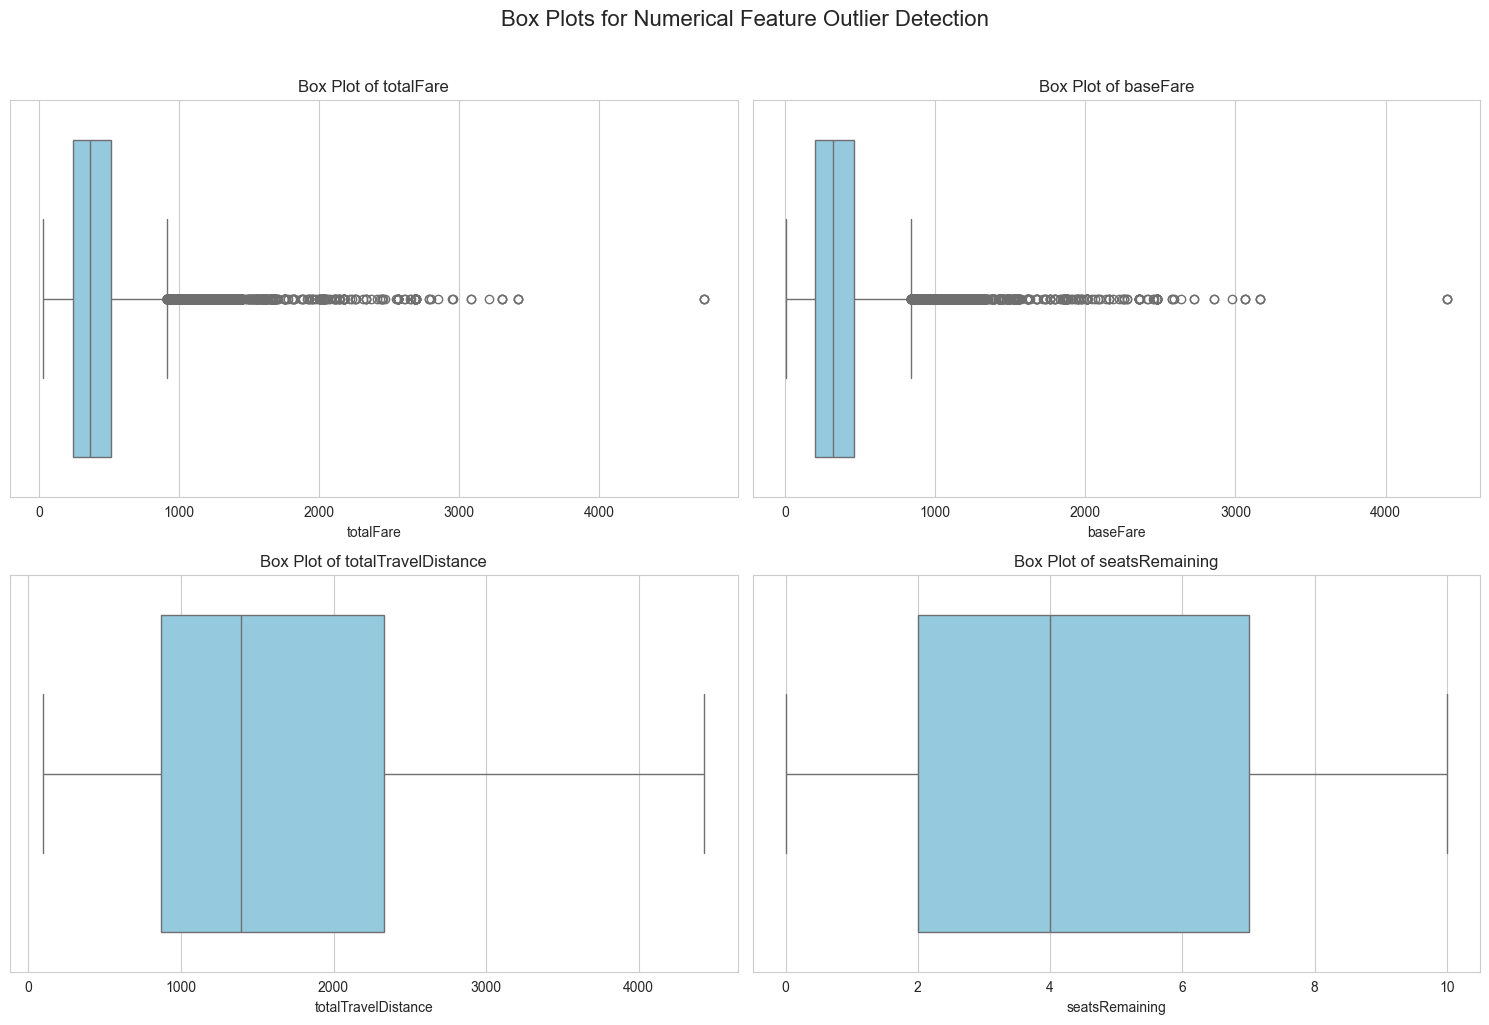


--- Top 5 Most Expensive Flights (Outliers) ---
       totalFare startingAirport destinationAirport  isNonStop
34589    4752.60             SFO                JFK       True
95655    4752.60             SFO                JFK       True
49094    4752.60             JFK                SFO       True
31378    3419.33             JFK                MIA      False
31377    3418.25             JFK                MIA      False


--- 2. Clustering Outliers with DBSCAN ---
Original data points: 112312, After dropping NaNs: 104771


/var/folders/vs/nb76g0hj0cg_x9_317mhxw880000gn/T/ipykernel_59675/1159737976.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data_clean['cluster'] = clusters



Cluster membership counts (DBSCAN):
cluster
 0    104336
-1       311
 1       124
Name: count, dtype: int64


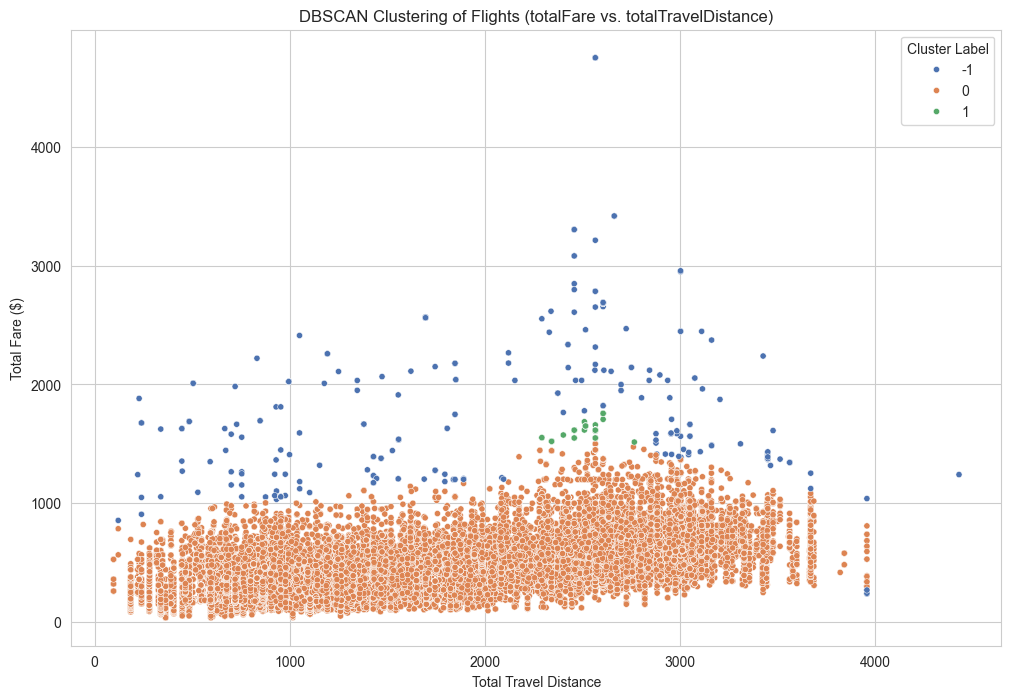

--- Outlier analysis complete ---


In [13]:
print("\n--- Starting Outlier Analysis ---")
print("--- 1. Box Plot Analysis (Fix Applied) ---")

# We can reuse the numerical columns list
num_cols = ['totalFare', 'baseFare', 'totalTravelDistance', 'seatsRemaining']

# Set up the plotting figure (2 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Box Plots for Numerical Feature Outlier Detection', fontsize=16, y=1.02)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a boxplot for each numerical column
for i, col in enumerate(num_cols):
    
    # --- FIX ---
    # Replaced 'palette="pastel"' with a single 'color'
    # This avoids the palette/hue conflict and the warning.
    sns.boxplot(
        data=data,
        x=col,
        ax=axes[i], # Assign plot to the correct subplot
        color='skyblue' # Use a single color
    )
    # --- End of Fix ---
    
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

# --- Deeper look at totalFare outliers ---
print("\n--- Top 5 Most Expensive Flights (Outliers) ---")
# Sort by 'totalFare' to see the most extreme examples
print(data.sort_values('totalFare', ascending=False)[['totalFare', 'startingAirport', 'destinationAirport', 'isNonStop']].head())


print("\n\n--- 2. Clustering Outliers with DBSCAN ---")

# --- a. Select & Clean data for clustering ---
# We'll cluster on two key features
cluster_features = ['totalFare', 'totalTravelDistance']
cluster_data = data[cluster_features].copy()

# DBSCAN cannot handle missing values, so we must drop them
cluster_data_clean = cluster_data.dropna()
print(f"Original data points: {len(cluster_data)}, After dropping NaNs: {len(cluster_data_clean)}")

# --- b. Scale the features ---
# This is critical for distance-based algorithms like DBSCAN
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data_clean)

# --- c. Run DBSCAN ---
# We set 'eps' (max distance) and 'min_samples'
# A low 'eps' and high 'min_samples' will find only very dense clusters
# 'min_samples=50' is a good starting point for a large dataset
db = DBSCAN(eps=0.35, min_samples=50)
clusters = db.fit_predict(cluster_data_scaled)

# Add cluster labels back to our clean data
cluster_data_clean['cluster'] = clusters
# Label -1 is "noise" (i.e., outliers). Other labels (0, 1, 2...) are "core" clusters.
print("\nCluster membership counts (DBSCAN):")
print(cluster_data_clean['cluster'].value_counts())


# --- d. Plot the clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cluster_data_clean,
    x='totalTravelDistance',
    y='totalFare',
    hue='cluster', # Color by the cluster label
    palette="deep",
    s=20 # Make points smaller to see patterns
)
plt.title('DBSCAN Clustering of Flights (totalFare vs. totalTravelDistance)')
plt.xlabel('Total Travel Distance')
plt.ylabel('Total Fare ($)')
plt.legend(title='Cluster Label')
plt.show()

print("--- Outlier analysis complete ---")

### Non-Numerical Features

## Feature Engineering

### Time-Based Features (The "Early Bird" Effect)
This category is often the most predictive for flight prices.

1. Idea: Booking Lead Time
Why it's smart: The single most powerful predictor of flight price is how far in advance it's booked. A flight booked 60 days out is almost always cheaper than the same flight booked 2 days out.

In [18]:
# we get a new dataframe for feature engineering
data_fe = data.copy()

# check if search date and flight date are pd.datetime objects
if pd.api.types.is_datetime64_any_dtype(data_raw['searchDate']):
    print("searchDate is a datetime object.")
else:
    print("searchDate is NOT a datetime object.")
    # convert to datetime
    data_fe['searchDate'] = pd.to_datetime(data['searchDate'])

if pd.api.types.is_datetime64_any_dtype(data_raw['flightDate']):
    print("flightDate is a datetime object.")
else:
    print("flightDate is NOT a datetime object.")
    # convert to datetime
    data_fe['flightDate'] = pd.to_datetime(data['flightDate'])

# Calculate the difference in days
data_fe['booking_lead_time_days'] = (data_fe['flightDate'] - data_fe['searchDate']).dt.days

print("\n--- Calculated Lead Time ---")
print(data_fe[['searchDate', 'flightDate', 'booking_lead_time_days']].head())
print(data_fe[['searchDate', 'flightDate', 'booking_lead_time_days']].max())

searchDate is a datetime object.
flightDate is a datetime object.

--- Calculated Lead Time ---
  searchDate flightDate  booking_lead_time_days
0 2022-05-11 2022-05-12                       1
1 2022-05-11 2022-05-12                       1
2 2022-05-11 2022-05-12                       1
3 2022-05-11 2022-05-12                       1
4 2022-05-11 2022-05-12                       1
searchDate                2022-05-11 00:00:00
flightDate                2022-05-24 00:00:00
booking_lead_time_days                     13
dtype: object


2. Idea: Departure Time & Day (The "Red-Eye" Effect)
Why it's smart: Flights at "inconvenient" times (like 5 AM red-eyes) are often cheaper. Flights on "commuter" days (Mondays, Fridays) can be more expensive than on "leisure" days (Tuesdays, Wednesdays).

In [20]:
# We use segment_1DepartureTimeRaw for the *actual* departure time
if pd.api.types.is_datetime64_any_dtype(data_fe['segment_1DepartureTimeRaw']):
    print("segment_1DepartureTimeRaw is a datetime object.")
else:
    print("segment_1DepartureTimeRaw is NOT a datetime object.")
    # convert to datetime
    data_fe['segment_1DepartureTime'] = pd.to_datetime(data_fe['segment_1DepartureTimeRaw'])

# Extract new features
data_fe['departure_hour'] = data_fe['segment_1DepartureTime'].dt.hour
data_fe['departure_day_of_week'] = data_fe['segment_1DepartureTime'].dt.dayofweek # Monday=0, Sunday=6
data_fe['departure_month'] = data_fe['segment_1DepartureTime'].dt.month

# Create a binary "is_weekend" feature
data_fe['is_weekend_departure'] = data_fe['departure_day_of_week'].isin([5, 6]) # Saturday or Sunday

print(data_fe[['segment_1DepartureTime', 'departure_hour', 'departure_day_of_week', 'is_weekend_departure']].head())

segment_1DepartureTimeRaw is a datetime object.
     segment_1DepartureTime  departure_hour  departure_day_of_week  \
0 2022-05-12 10:25:00+00:00              10                      3   
1 2022-05-12 22:12:00+00:00              22                      3   
2 2022-05-12 23:56:00+00:00              23                      3   
3 2022-05-12 12:44:00+00:00              12                      3   
4 2022-05-12 15:09:00+00:00              15                      3   

   is_weekend_departure  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  


### Layover & Route Features (The "Pain Factor")
This category quantifies the "inconvenience" of the itinerary, which often correlates with price.

1. Idea: Total Layover Time
Why it's smart: A direct flight (zero layover) is different from a 10-hour trip with 4 hours of flying and 6 hours of layovers. More "pain" (layover time) should mean a lower price, all else being equal.

In [21]:
# 1. Convert the 'travelDuration' (e.g., 'PT4H39M') to total seconds
if pd.api.types.is_timedelta64_dtype(data_fe['travelDuration']):
    print("travelDuration is already a timedelta object.")
else:
    print("travelDuration is NOT a timedelta object.")
    data_fe['total_travel_seconds'] = pd.to_timedelta(data_fe['travelDuration']).dt.total_seconds()

# 2. Find all segment duration columns
duration_cols = [f'segment_{i}DurationInSeconds' for i in range(1, 5)] # 1 to 4

# 3. Convert them to numeric, filling NaNs (for non-stop, 2-stop, etc.) with 0
for col in duration_cols:
    data_fe[col] = pd.to_numeric(data_fe[col], errors='coerce').fillna(0)

# 4. Sum the *flight* durations
data_fe['total_flight_seconds'] = data_fe[duration_cols].sum(axis=1)

# 5. Calculate total layover time
data_fe['total_layover_seconds'] = data_fe['total_travel_seconds'] - data_fe['total_flight_seconds']

# Optional: Convert to hours for easier interpretation
data_fe['total_layover_hours'] = data_fe['total_layover_seconds'] / 3600

# Handle non-stop flights which might have tiny negative layover from rounding
data_fe.loc[data_fe['num_stops'] == 0, 'total_layover_seconds'] = 0
data_fe.loc[data_fe['num_stops'] == 0, 'total_layover_hours'] = 0

print(data_fe[['travelDuration', 'total_travel_seconds', 'total_flight_seconds', 'total_layover_hours', 'num_stops']].head())

travelDuration is NOT a timedelta object.
  travelDuration  total_travel_seconds  total_flight_seconds  \
0        PT2H35M                9300.0                9300.0   
1        PT4H39M               16740.0               12900.0   
2        PT4H44M               17040.0               12600.0   
3        PT4H56M               17760.0               13260.0   
4         PT6H5M               21900.0               13080.0   

   total_layover_hours  num_stops  
0             0.000000          0  
1             1.066667          1  
2             1.233333          1  
3             1.250000          1  
4             2.450000          1  


### Airline & Equipment Features (The "Brand Effect")
This category leverages the (now known) list of airlines.

1. Idea: Budget vs. Premium Airline
Why it's smart: Some airlines are explicitly "budget" (Spirit, Frontier) and compete on price, while others are "premium" and may command higher fares.

for this we again create an new ordinal feature with 3 levels:
- 0: Ultra-Low-Cost Carrier (ULCC)
- 1: Low-Cost Carrier (LCC)
- 2: Full-Service, Legacy, or Regional Carrier

In [24]:
# get unique airlines names
unique_airlines = data_fe['segment_1AirlineName'].dropna().unique().tolist()
print(f"Number of unique airlines in segment 1: {len(unique_airlines)}")
print(f"Unique airlines in segment 1: {unique_airlines}")

# 1. Define the ordinal mapping for budget levels
# 0 = Ultra-Low-Cost, 1 = Low-Cost, 2 = Full-Service/Legacy/Other
airline_budget_map = {
    # Ultra-Low-Cost (ULCC)
    'Spirit Airlines': 0,
    'Frontier Airlines': 0,
    'Sun Country Airlines': 0,
    
    # Low-Cost (LCC)
    'JetBlue Airways': 1,
    
    # Full-Service / Legacy
    'American Airlines': 2,
    'United': 2,
    'Delta': 2,
    'Alaska Airlines': 2,
    
    # Regional / Commuter / Charter
    'Cape Air': 2,
    'Key Lime Air': 2,
    'Boutique Air': 2,
    'Southern Airways Express': 2
}

# 2. Create the new ordinal feature 'airline_budget_level'
# .map() will apply the dictionary values.
# Airlines not found in the map will become NaN (Not a Number).
data_fe['airline_budget_level'] = data_fe['segment_1AirlineName'].map(airline_budget_map)

# 3. (Optional but recommended) Fill any potential NaN values
# If an airline wasn't in your map, it's safest to classify it as 'Other' (2).
data_fe['airline_budget_level'] = data_fe['airline_budget_level'].fillna(2)

# 4. Convert to integer (optional, as NaNs force the column to be float)
data_fe['airline_budget_level'] = data_fe['airline_budget_level'].astype(int)


# Print the result to verify
print(data_fe[['segment_1AirlineName', 'airline_budget_level']].head(10))

Number of unique airlines in segment 1: 12
Unique airlines in segment 1: ['Spirit Airlines', 'American Airlines', 'JetBlue Airways', 'United', 'Delta', 'Frontier Airlines', 'Alaska Airlines', 'Sun Country Airlines', 'Cape Air', 'Key Lime Air', 'Boutique Air', 'Southern Airways Express']
  segment_1AirlineName  airline_budget_level
0      Spirit Airlines                     0
1    American Airlines                     2
2    American Airlines                     2
3    American Airlines                     2
4    American Airlines                     2
5    American Airlines                     2
6    American Airlines                     2
7    American Airlines                     2
8    American Airlines                     2
9    American Airlines                     2


2.  Idea: Budget vs Premium Airport
The same concept can be applied to airports

In [27]:
# get unique airports names
unique_startingAirports = data_fe['startingAirport'].dropna().unique().tolist()
unique_destinationAirports = data_fe['destinationAirport'].dropna().unique().tolist()

print(f"Number of unique starting airports: {len(unique_startingAirports)}")
print(f"Unique starting airports: {unique_startingAirports}")
print(f"Number of unique destination airports: {len(unique_destinationAirports)}")
print(f"Unique destination airports: {unique_destinationAirports}")


# 1. Define the ordinal mapping for airport traffic levels
# Based on 2023 passenger traffic data.
# 0 = Tier 0 (Mega Hub, >70M passengers/year)
# 1 = Tier 1 (Major Hub, 40M-70M passengers/year)
# 2 = Tier 2 (Large Airport, <40M passengers/year)
airport_traffic_map = {
    # Tier 0: Mega Hubs (>70M)
    'ATL': 0,
    'DFW': 0,
    'DEN': 0,
    'LAX': 0,
    'ORD': 0,
    
    # Tier 1: Major Hubs (40M-70M)
    'JFK': 1,
    'CLT': 1,
    'MIA': 1,
    'SFO': 1,
    'EWR': 1,
    'BOS': 1,
    
    # Tier 2: Large Airports (<40M)
    'LGA': 2,
    'DTW': 2,
    'PHL': 2,
    'IAD': 2,
    'OAK': 2  # Oakland is significantly smaller than the others in this list
}

# 2. Create the new ordinal features for both columns
data_fe['start_airport_traffic_level'] = data_fe['startingAirport'].map(airport_traffic_map)
data_fe['dest_airport_traffic_level'] = data_fe['destinationAirport'].map(airport_traffic_map)

# 3. (Optional but recommended) Fill any potential NaN values
# If an airport wasn't in the map, we'll place it in the least-busy tier (2).
data_fe['start_airport_traffic_level'] = data_fe['start_airport_traffic_level'].fillna(2)
data_fe['dest_airport_traffic_level'] = data_fe['dest_airport_traffic_level'].fillna(2)

# 4. Convert new columns to integer
data_fe['start_airport_traffic_level'] = data_fe['start_airport_traffic_level'].astype(int)
data_fe['dest_airport_traffic_level'] = data_fe['dest_airport_traffic_level'].astype(int)

# Print the result to verify
print(data_fe[['startingAirport', 'start_airport_traffic_level', 'destinationAirport', 'dest_airport_traffic_level']].head(10))

Number of unique starting airports: 16
Unique starting airports: ['ATL', 'BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAD', 'JFK', 'LAX', 'LGA', 'MIA', 'OAK', 'ORD', 'PHL', 'SFO']
Number of unique destination airports: 16
Unique destination airports: ['BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAD', 'JFK', 'LAX', 'LGA', 'MIA', 'OAK', 'ORD', 'PHL', 'SFO', 'ATL']
  startingAirport  start_airport_traffic_level destinationAirport  \
0             ATL                            0                BOS   
1             ATL                            0                BOS   
2             ATL                            0                BOS   
3             ATL                            0                BOS   
4             ATL                            0                BOS   
5             ATL                            0                BOS   
6             ATL                            0                BOS   
7             ATL                            0                BOS   
8             ATL

## Correlation Analysis with Engineered Data

--- Top Features by Absolute Pearson Correlation with totalFare (showing Pearson & Spearman) ---
                                     pearson  spearman
baseFare                            0.996818  0.994071
totalTravelDistance                 0.567445  0.606009
total_flight_seconds                0.535091  0.577453
total_travel_seconds                0.423657  0.480815
travelDuration_minutes              0.423657  0.480815
segment_2Distance                   0.340433  0.296538
segment_2DurationInSeconds          0.322043  0.340285
num_segments                        0.309377  0.350237
num_stops                           0.309377  0.350237
segment_1Distance                   0.304161  0.267186
segment_1DurationInSeconds          0.273864  0.225036
segment_3DurationInSeconds          0.260728  0.277807
total_layover_hours                 0.227293  0.290480
total_layover_seconds               0.227293  0.290480
segment_4Distance                  -0.211070 -0.061416
airline_budget_level   

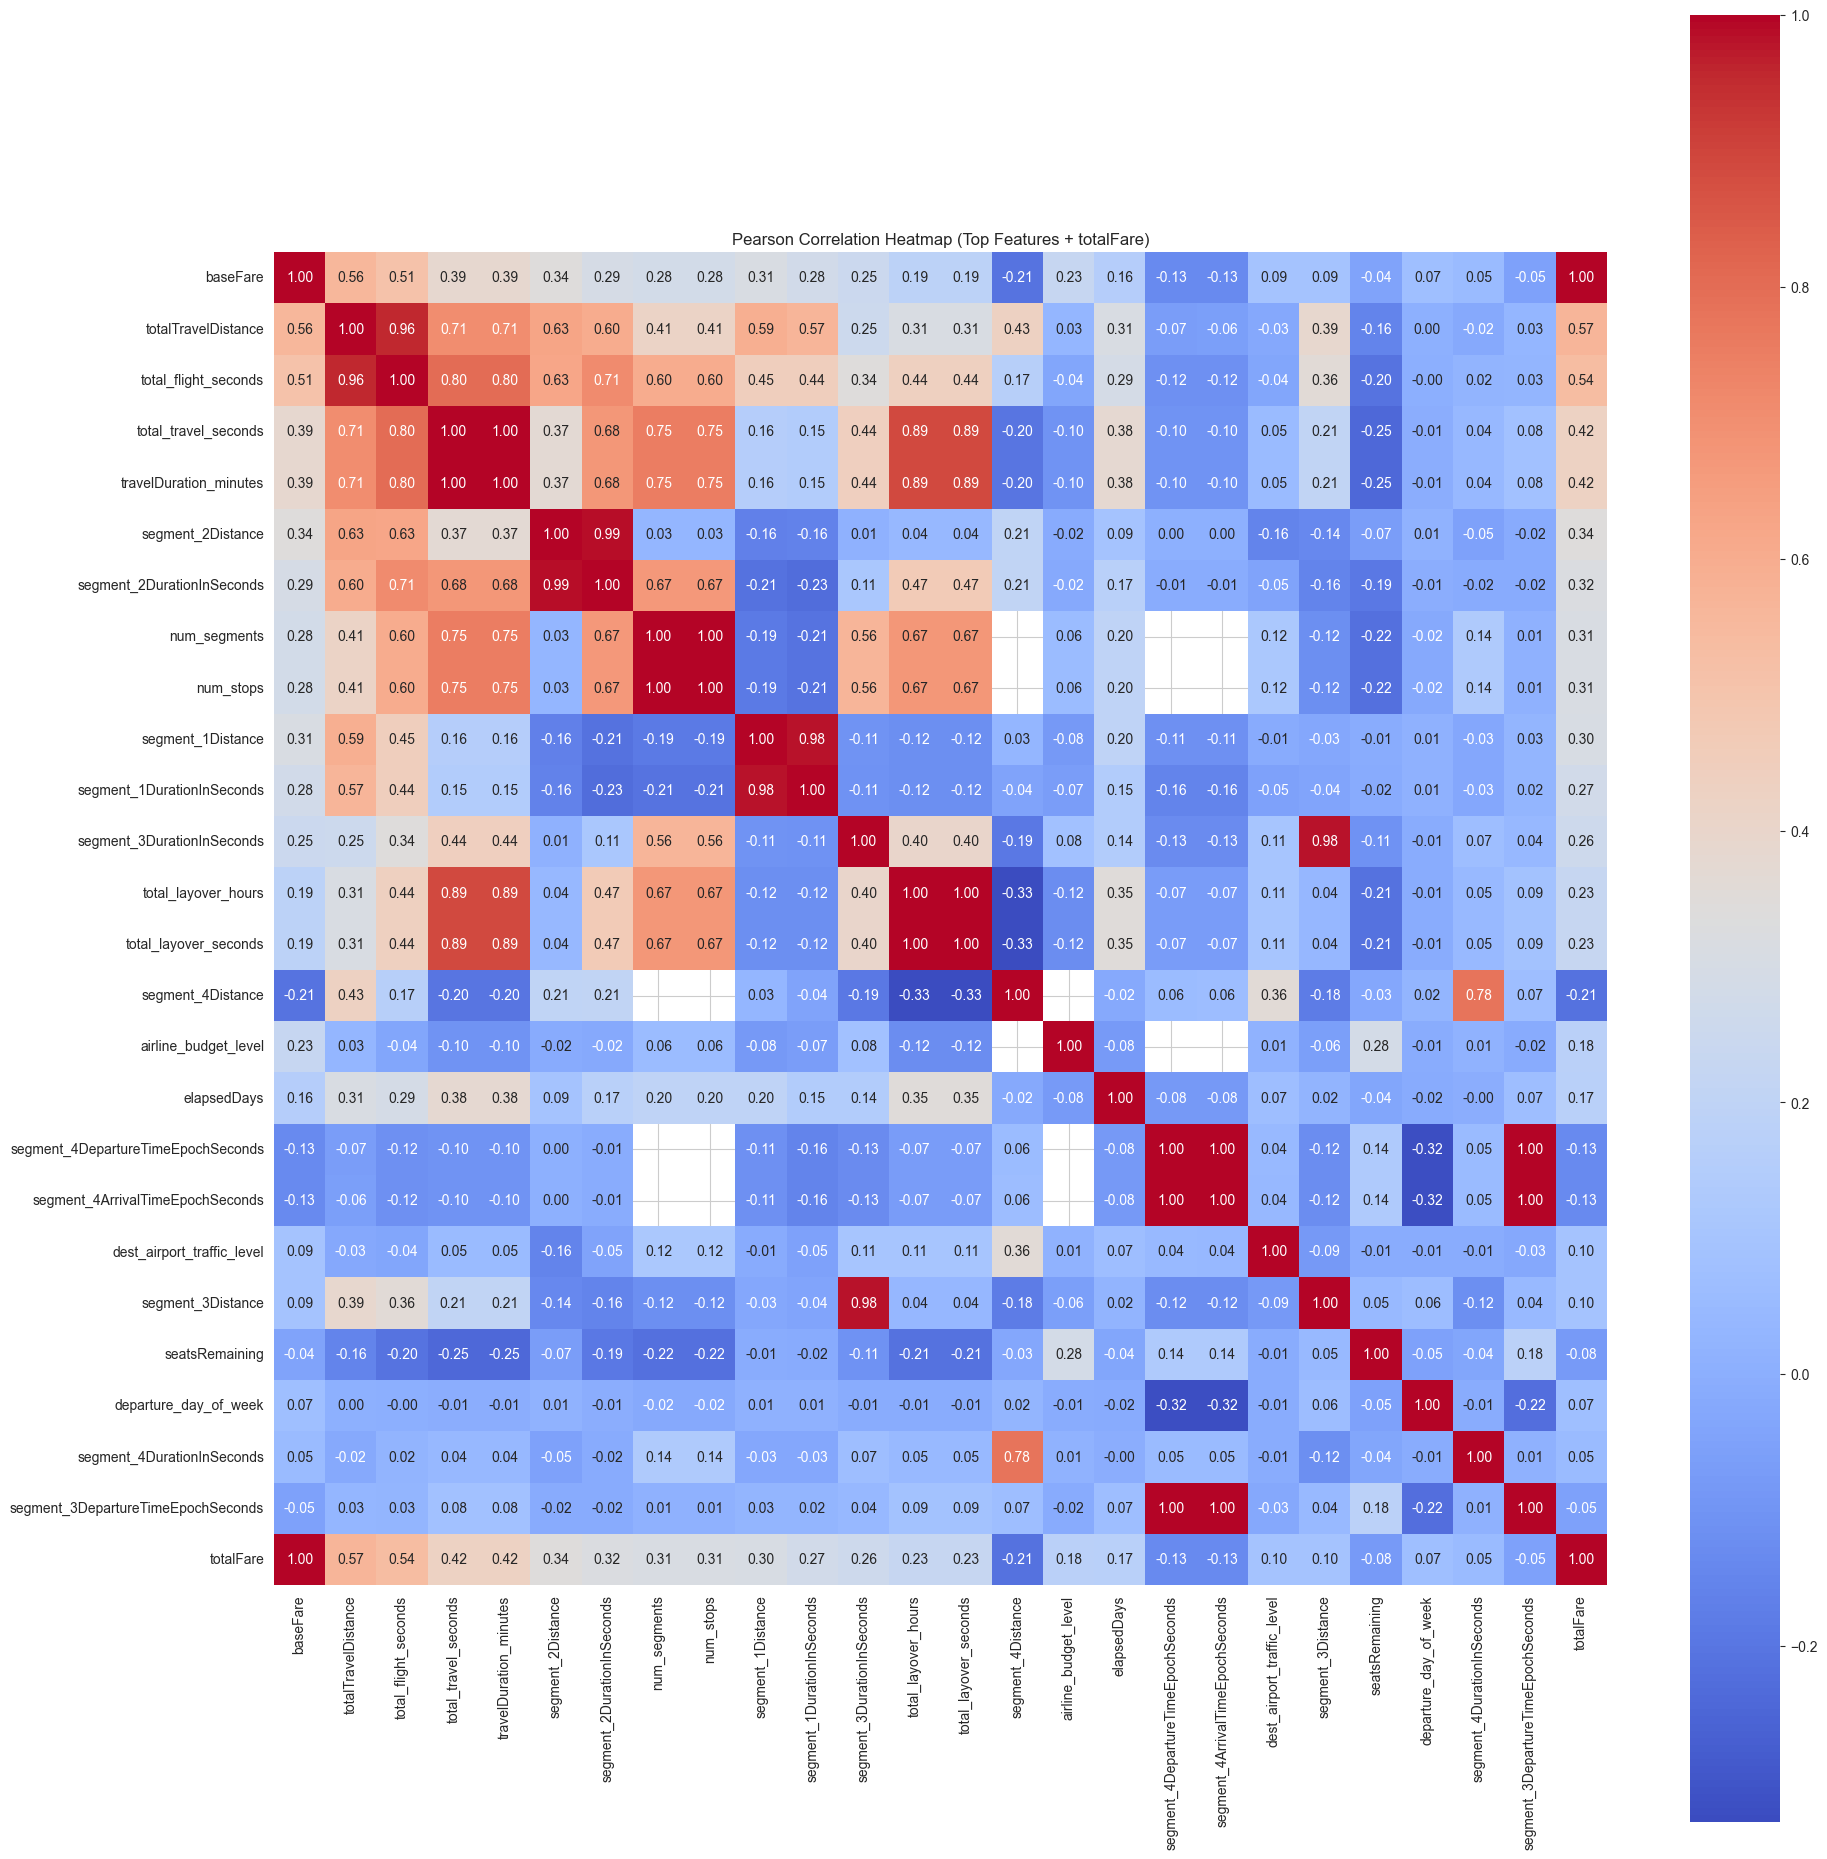

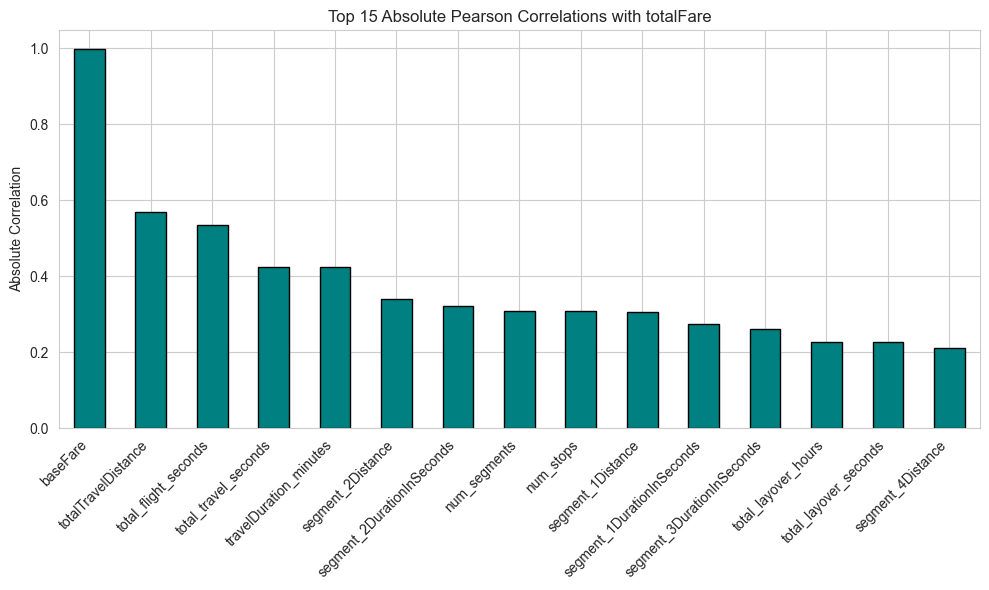


--- Strongest Negative Pearson Correlations (Potential Inverse Relationships) ---
segment_4Distance                    -0.211070
segment_4DepartureTimeEpochSeconds   -0.134527
segment_4ArrivalTimeEpochSeconds     -0.134371
seatsRemaining                       -0.078748
segment_3DepartureTimeEpochSeconds   -0.052065
segment_3ArrivalTimeEpochSeconds     -0.051499
departure_hour                       -0.048102
Name: totalFare, dtype: float64

statsmodels not installed; skipping VIF computation.

--- Correlation analysis complete ---


In [30]:
# Correlation Analysis for Engineered Features vs. totalFare
# -----------------------------------------------------------
# We focus on how our engineered and original numeric features relate to the target `totalFare`.

# 1. Collect numeric columns
numeric_cols = data_fe.select_dtypes(include=[np.number]).columns.tolist()

# 2. Drop leakage-like IDs or columns that are not meaningful for modeling correlation
leakage_or_id = [
    'legId',  # pure identifier
]
numeric_cols = [c for c in numeric_cols if c not in leakage_or_id]

# 3. Ensure target exists
assert 'totalFare' in numeric_cols, "totalFare not found among numeric columns."

# 4. Compute Pearson correlations
pearson_corr_series = data_fe[numeric_cols].corr(method='pearson')['totalFare'].drop('totalFare').sort_values(ascending=False)

# 5. Compute Spearman (rank) correlations (robust to non-linear monotonic relationships)
spearman_corr_series = data_fe[numeric_cols].corr(method='spearman')['totalFare'].drop('totalFare').sort_values(ascending=False)

# 6. Combine into a single DataFrame for comparison
top_n = 25  # number of top features to inspect
corr_compare_df = (
    pd.DataFrame({
        'pearson': pearson_corr_series,
        'spearman': spearman_corr_series
    })
    .assign(abs_pearson=lambda df: df['pearson'].abs(), abs_spearman=lambda df: df['spearman'].abs())
    .sort_values('abs_pearson', ascending=False)
)

print("--- Top Features by Absolute Pearson Correlation with totalFare (showing Pearson & Spearman) ---")
print(corr_compare_df[['pearson', 'spearman']])

# 7. Visualize: Heatmap of top absolute Pearson correlations
heatmap_features = corr_compare_df.head(25).index.tolist()
heatmap_df = data_fe[heatmap_features + ['totalFare']].corr(method='pearson')

plt.figure(figsize=(0.6 * len(heatmap_df.columns) + 4, 0.6 * len(heatmap_df.columns) + 4))
sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Pearson Correlation Heatmap (Top Features + totalFare)')
plt.tight_layout()
plt.show()

# 8. Bar plot of top_k absolute correlations for quick view
top_k = 15
abs_corr = pearson_corr_series.abs().sort_values(ascending=False).head(top_k)
plt.figure(figsize=(10, 6))
abs_corr.plot(kind='bar', color='teal', edgecolor='black')
plt.title(f'Top {top_k} Absolute Pearson Correlations with totalFare')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 9. Report strongest negative Pearson correlations separately (could indicate inverse price drivers)
neg_corr = pearson_corr_series[pearson_corr_series < 0].sort_values().head(10)
if not neg_corr.empty:
    print("\n--- Strongest Negative Pearson Correlations (Potential Inverse Relationships) ---")
    print(neg_corr)
else:
    print("\nNo negative Pearson correlations among inspected features.")

# 10. Quick sanity check for multicollinearity (variance inflation factor) - optional lightweight
# We'll compute VIF for the top_n features to identify redundancy.
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_features = heatmap_features  # use same set as heatmap
    X_vif = data_fe[vif_features].dropna()  # drop NaNs for VIF computation
    # To avoid singular matrix issues, we only compute if we have > top features rows
    if X_vif.shape[0] > len(vif_features):
        vif_vals = []
        for i, col in enumerate(vif_features):
            vif = variance_inflation_factor(X_vif.values, i)
            vif_vals.append((col, vif))
        vif_df = pd.DataFrame(vif_vals, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
        print("\n--- Variance Inflation Factor (Higher => More Multicollinearity) ---")
        print(vif_df)
    else:
        print("\nSkipped VIF (insufficient non-null rows).")
except ImportError:
    print("\nstatsmodels not installed; skipping VIF computation.")
except Exception as e:
    print(f"\nVIF computation encountered an issue: {e}")

print("\n--- Correlation analysis complete ---")

### Assessing the Engineered Features (With Correlation Values)

Below we interpret the engineered features using the observed Pearson and Spearman correlations with `totalFare` from the correlation table. Remember: linear correlation only captures straight-line or monotonic relationships (Spearman). Features with low values may still matter via interactions or non-linear effects.

| Feature | Pearson | Spearman | Notes |
|---------|---------|----------|-------|
| `baseFare` | 0.997 | 0.994 | Almost perfectly explains total fare (expected, risk of leakage if predicting totalFare). Consider excluding for predictive modeling if target is total fare including baseFare.
| `totalTravelDistance` | 0.567 | 0.606 | Strong positive; longer itineraries cost more. Good candidate.
| `total_flight_seconds` | 0.535 | 0.577 | Flight time itself closely tracks fare; correlated with distance. Watch multicollinearity (VIF) vs. distance.
| `total_travel_seconds` | 0.424 | 0.481 | Total itinerary duration adds signal beyond pure flight time (layovers). Moderately useful.
| `travelDuration_minutes` | 0.424 | 0.481 | Same information as `total_travel_seconds` (redundant). Keep only one.
| `num_segments` | 0.309 | 0.350 | More segments, higher price. Captures itinerary complexity.
| `num_stops` | 0.309 | 0.350 | Redundant with `num_segments` (segments = stops + 1). Pick one.
| `segment_2Distance` | 0.340 | 0.297 | Middle leg length associated with fare—interaction opportunity.
| `segment_2DurationInSeconds` | 0.322 | 0.340 | Similar to distance.
| `segment_1Distance` | 0.304 | 0.267 | First leg distance predictive. Consider aggregations (mean / max segment distance).
| `segment_1DurationInSeconds` | 0.274 | 0.225 | Flight time first leg; overlaps with distance.
| `segment_3DurationInSeconds` | 0.261 | 0.278 | Third leg duration shows monotonic pattern (Spearman slightly higher). Sparse usage—check missing coverage.
| `total_layover_hours` | 0.227 | 0.290 | Positive relationship (layovers increase price here—even if we might expect inverse). Might reflect complex / multi-city itineraries. Spearman > Pearson suggests monotonic but non-linear trend.
| `total_layover_seconds` | 0.227 | 0.290 | Duplicate of hours (choose one).
| `airline_budget_level` | 0.176 | 0.200 | Premium carriers priced higher; ordinal mapping appears meaningful (Spearman higher than Pearson). Keep.
| `elapsedDays` | 0.170 | 0.201 | Overnight/next-day trips more expensive. Treat as categorical (0/1) or keep numeric.
| `dest_airport_traffic_level` | 0.096 | 0.084 | Weak positive; busier destination airports slightly pricier. Try interaction with origin.
| `segment_3Distance` | 0.095 | 0.137 | Spearman > Pearson: possible monotonic but non-linear effect. Sparse segment—verify coverage.
| `seatsRemaining` | -0.079 | -0.080 | Mild inverse: fewer seats remaining -> higher fare (yield management). Despite low magnitude, directionally sensible.
| `departure_day_of_week` | 0.075 | 0.067 | Small effect; likely stronger with one-hot encoding. Interaction with business vs leisure routes could amplify.
| `start_airport_traffic_level` | 0.042 | 0.020 | Minimal standalone value; rely on interactions (`start * dest`).
| `segment_4Distance` | -0.211 | -0.061 | Pearson moderate negative but Spearman weak → potential linear artifact due to few 4-segment cases. Treat cautiously; high sparsity risk.
| `segment_4DepartureTimeEpochSeconds` | -0.135 | -0.201 | Negative (later epoch maybe cheaper or encoding artifact). Validate with time-of-day transformation.
| `segment_4ArrivalTimeEpochSeconds` | -0.134 | -0.201 | Similar pattern; consider aggregating departure/arrival statistics instead of raw epoch.
| `segment_3DepartureTimeEpochSeconds` | -0.052 | -0.051 | Very weak; likely dispensable.
| `segment_3ArrivalTimeEpochSeconds` | -0.051 | -0.050 | Same.
| `departure_hour` | -0.048 | -0.048 | Low linear signal; try cyclical (sin/cos) or binning (e.g., red-eye, early, peak, evening). Might improve in non-linear models.
| `segment_2ArrivalTimeEpochSeconds` | 0.044 | 0.061 | Weak; may be replaced by derived layover metrics.
| `segment_2DepartureTimeEpochSeconds` | 0.040 | 0.056 | Same.
| `segment_1ArrivalTimeEpochSeconds` | 0.013 | 0.024 | Negligible alone.
| `segment_1DepartureTimeEpochSeconds` | 0.009 | 0.020 | Negligible alone.
| `booking_lead_time_days` | 0.005 | 0.016 | Surprisingly near-zero (dataset limited to a single search date?); might not vary enough. Potentially drop unless interaction proves value.
| `departure_month` | NaN | NaN | No variance (single month) or conversion issue—safe to drop.
| `is_weekend_departure` | (Not listed) | (Not listed) | Likely low variance or encoded as boolean not in numeric list; evaluate after converting to int. Expect mild effect.

#### Key Observations
- High (>0.5) correlations: Distance and flight duration metrics. They risk multicollinearity—consider selecting one representative or deriving `avg_segment_speed = totalTravelDistance / (total_flight_seconds/3600)`.
- Moderate (0.2–0.5): Layover time, number of stops, airline budget level, elapsedDays. Worth keeping.
- Low (<0.1): Lead time (almost constant here), weekday, airport tiers individually—retain only if interactions or non-linear encodings provide lift.
- Negative correlations: `segment_4Distance`, seat availability (`seatsRemaining`), some late-segment timestamps. Investigate sparsity and distribution to avoid noisy signals.

#### Recommended Refinements
1. Remove redundant twins: Keep `total_flight_seconds`, drop `travelDuration_minutes` and `total_travel_seconds` (or derive ratio features). Keep only one of `total_layover_hours` vs `total_layover_seconds`.
2. Consolidate segment-level distance/duration into aggregates: `sum_segment_distance`, `max_segment_distance`, `mean_segment_duration` to reduce dimensionality.
3. Engineer interaction features with promise: 
   - `distance_per_stop = totalTravelDistance / (num_stops + 1)`
   - `premium_route = airline_budget_level * (start_airport_traffic_level + dest_airport_traffic_level)`
   - Cyclical encoding: `sin(2π * departure_hour/24)`, `cos(2π * departure_hour/24)`.
4. Address sparsity of segment 4 features: Consider dropping unless model importance justifies keeping.
5. Exclude `baseFare` if predicting `totalFare` to avoid trivial leakage (or redefine target as taxes/fees residual).
6. Revisit `booking_lead_time_days` when you have multiple search dates—currently near-zero correlation likely due to restricted variation.

#### Validation Plan
- Train baseline model without engineered features (excluding `baseFare`).
- Add engineered features incrementally (time, itinerary, carrier, airport) and record MAE/RMSE delta.
- Use SHAP/Permutation importance for a tree model (e.g., LightGBM) to confirm which engineered features add marginal gain beyond distance/duration.
- Conduct VIF on selected subset; remove features with VIF > 10 unless strongly justified.

#### Summary
Engineered features mostly align with airfare pricing logic: itinerary complexity (`num_stops`), carrier tier, layover time, and elapsed days contribute moderate, meaningful signal. Low-correlation features should be transformed or combined to unlock potential interactions. After de-duplication and aggregation, proceed to modeling and interpretability to confirm real predictive lift.

> Next: Implement a modeling cell comparing baseline vs. engineered feature set.

## Model Training Pipeline Setup

We now prepare data for modeling. Goals:
- Define `y = totalFare` (target).
- Create two feature matrices:
  1. `X` (original cleaned numeric/categorical features before engineered additions).
  2. `X_fe` (includes engineered features like layover metrics, booking lead time, airline/airport tiers).
- Explicitly drop `baseFare` to avoid leakage (it is nearly perfectly correlated with `totalFare` and would trivialize prediction).
- Exclude pure identifiers (`legId`) and any columns still in raw string / high-cardinality timestamp form that will be transformed later.

Next cell performs the split and prints shapes + a few sanity checks. After this we can proceed to encoding, scaling, and baseline vs enhanced model comparison.

In [31]:
# Create feature / target splits (baseline vs engineered)
# -----------------------------------------------------

# Columns to drop from both feature sets
drop_cols_common = [
    'totalFare',      # target
    'baseFare',       # leakage risk
    'legId'           # pure identifier
]

# (Optional) columns that are raw timestamps and may need transformation later; can drop now
raw_time_cols = [c for c in data.columns if 'TimeRaw' in c]
engineered_time_cols = []  # Already converted engineered versions if any

# Build X (baseline)
X = data.drop(columns=[col for col in drop_cols_common if col in data.columns])
X = X.drop(columns=[col for col in raw_time_cols if col in X.columns])  # remove raw timestamp strings

# Build X_fe (engineered). We may have additional engineered columns like booking_lead_time_days, etc.
X_fe = data_fe.drop(columns=[col for col in drop_cols_common if col in data_fe.columns])
X_fe = X_fe.drop(columns=[col for col in raw_time_cols if col in X_fe.columns])  # ensure consistency

# Target vector
y = data['totalFare']

print("Baseline feature matrix shape (X):", X.shape)
print("Engineered feature matrix shape (X_fe):", X_fe.shape)
print("Target vector shape (y):", y.shape)

# Quick sanity checks
print("\nColumns removed (common):", drop_cols_common)
print("Raw time columns removed:", raw_time_cols)

# Show a sample of columns difference
baseline_only = sorted(set(X.columns) - set(X_fe.columns))
engineered_only = sorted(set(X_fe.columns) - set(X.columns))
print(f"\nBaseline-only columns (count={len(baseline_only)}):", baseline_only[:25])
print(f"Engineered-only columns (count={len(engineered_only)}):", engineered_only[:25])

# Verify no leakage columns in feature sets
assert 'baseFare' not in X.columns and 'baseFare' not in X_fe.columns, "baseFare still present in features!"
assert 'totalFare' not in X.columns and 'totalFare' not in X_fe.columns, "totalFare should not be in features!"

# Store for later modeling steps
feature_sets = {
    'baseline': X,
    'engineered': X_fe,
    'target': y
}
print("\nFeature sets prepared and stored in 'feature_sets' dict.")

Baseline feature matrix shape (X): (112312, 55)
Engineered feature matrix shape (X_fe): (112312, 68)
Target vector shape (y): (112312,)

Columns removed (common): ['totalFare', 'baseFare', 'legId']
Raw time columns removed: ['segment_1DepartureTimeRaw', 'segment_2DepartureTimeRaw', 'segment_3DepartureTimeRaw', 'segment_4DepartureTimeRaw', 'segment_1ArrivalTimeRaw', 'segment_2ArrivalTimeRaw', 'segment_3ArrivalTimeRaw', 'segment_4ArrivalTimeRaw']

Baseline-only columns (count=0): []
Engineered-only columns (count=13): ['airline_budget_level', 'booking_lead_time_days', 'departure_day_of_week', 'departure_hour', 'departure_month', 'dest_airport_traffic_level', 'is_weekend_departure', 'segment_1DepartureTime', 'start_airport_traffic_level', 'total_flight_seconds', 'total_layover_hours', 'total_layover_seconds', 'total_travel_seconds']

Feature sets prepared and stored in 'feature_sets' dict.
